In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import time
from pathlib import Path
from sampling import f_theta_sampler
from agginc_test import agginc
from ost_test import ost
from lsd_test import lsd_test, generate_rbm_p

sys.path.append('wittawatj/fsic_test')
sys.path.append('wittawatj/interpretable_test')
sys.path.append('wittawatj/kernel_gof')
sys.path.append('random-feature-stein-discrepancies')
from wittawatj_tests import nfsic, fssd, met, scf
from kgof.density import GaussBernRBM as kgof_GaussBernRBM
from l1imq_test import L1_IMQ_test
from rff_cauchy_test import rff_cauchy_test

/home/antonin/miniconda3/envs/agginc-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Path("results").mkdir(exist_ok=True, parents=True)
Path("figures").mkdir(exist_ok=True, parents=True)

# MMD

In [2]:
mmdagginc1 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=1, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc100 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=100, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc200 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=200, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdaggincquad = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ost_test = lambda X, Y, seed : ost(seed, X, Y, alpha=0.05, kernel_type="gaussian", l_minus=-3, l_plus=0)

mmdagginc1_m10 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc100_m10 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=100, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc200_m10 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=200, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdaggincquad_m10 = lambda X, Y, seed : agginc("mmd", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ost_test_m10 = lambda X, Y, seed : ost(seed, X, Y, alpha=0.05, kernel_type="gaussian", l_minus=-10, l_plus=10)

## MMD vary N

In [10]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
rep = 100
mult = 2

tests_mmd_vary_n = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_n = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_mmd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d)) 
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/mmd_vary_n.npy", outputs_mmd_vary_n)

In [ ]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
rep = 100
mult = 2

tests_mmd_vary_n = [mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_vary_n = ["mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_mmd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d)) 
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/mmd_vary_n_10.npy", outputs_mmd_vary_n)

In [ ]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
rep = 100
mult = 2

tests_mmd_vary_n = [ost_test_m10, ]
tests_names_mmd_vary_n = ["ost_test_m10", ]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_mmd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d)) 
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/mmd_vary_n_ost_m10.npy", outputs_mmd_vary_n)


In [11]:
x = np.load("results/mmd_vary_n.npy")
mmd_vary_n_met = np.mean(x, -1)[0]
mmd_vary_n_scf = np.mean(x, -1)[1]

x = np.load("results/mmd_vary_n_m10.npy")
mmd_vary_n_mmdagginc1_m10 = np.mean(x, -1)[0]
mmd_vary_n_mmdagginc100_m10 = np.mean(x, -1)[1]
mmd_vary_n_mmdagginc200_m10 = np.mean(x, -1)[2]
mmd_vary_n_mmdaggincquad_m10 = np.mean(x, -1)[3]

x = np.load("results/mmd_vary_n_ost_m10.npy")
mmd_vary_n_ost_m10 = np.mean(x, -1)[0]

mmd_vary_n = np.array([
    mmd_vary_n_met,
    mmd_vary_n_scf,
    mmd_vary_n_ost_m10,
    mmd_vary_n_mmdagginc1_m10,
    mmd_vary_n_mmdagginc100_m10,
    mmd_vary_n_mmdagginc200_m10,
    mmd_vary_n_mmdaggincquad_m10,
])

x_axis_mmd_vary_n = [200, 400, 600, 800, 1000]

names_mmd_vary_n = ["met", "scf", "ost_test_m10", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]


[[0.38 0.56 0.78 0.89 0.97]
 [0.03 0.14 0.27 0.56 0.68]
 [0.09 0.05 0.06 0.11 0.04]
 [0.05 0.06 0.08 0.07 0.11]
 [0.35 0.74 0.89 0.98 0.98]
 [0.45 0.84 0.96 0.98 0.98]
 [0.45 0.89 0.97 0.99 0.99]]


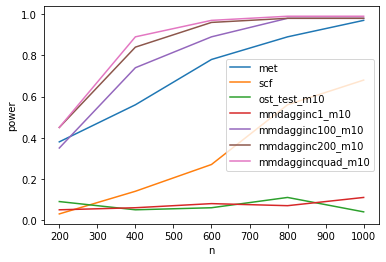

In [12]:
power = mmd_vary_n
tests_names = names_mmd_vary_n
x_axis = x_axis_mmd_vary_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("power")
print(power) 

## MMD vary d

In [17]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1

tests_mmd_vary_d = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_d = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_d

d_values = [1, 2, 3, 4]
x_axis_mmd_vary_d = d_values
outputs_mmd_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/mmd_vary_d.npy", outputs_mmd_vary_d)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1

tests_mmd_vary_d = [mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_vary_d = ["mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_vary_d

d_values = [1, 2, 3, 4]
x_axis_mmd_vary_d = d_values
outputs_mmd_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/mmd_vary_d_m10.npy", outputs_mmd_vary_d)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1

tests_mmd_vary_d = [ost_test_m10, ]
tests_names_mmd_vary_d = ["ost_test_m10", ]
tests = tests_mmd_vary_d

d_values = [1, 2, 3, 4]
x_axis_mmd_vary_d = d_values
outputs_mmd_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_d[j][r][i] = test(X, Y, seed)
np.save("results/mmd_vary_d_ost_m10.npy", outputs_mmd_vary_d)

In [5]:
x = np.load("results/mmd_vary_d.npy")
mmd_vary_d_met = np.mean(x, -1)[0]
mmd_vary_d_scf = np.mean(x, -1)[1]

x = np.load("results/mmd_vary_d_m10.npy")
mmd_vary_d_mmdagginc1_m10 = np.mean(x, -1)[0]
mmd_vary_d_mmdagginc100_m10 = np.mean(x, -1)[1]
mmd_vary_d_mmdagginc200_m10 = np.mean(x, -1)[2]
mmd_vary_d_mmdaggincquad_m10 = np.mean(x, -1)[3]

x = np.load("results/mmd_vary_d_ost_m10.npy")
mmd_vary_d_ost_m10 = np.mean(x, -1)[0]

mmd_vary_d = np.array([
    mmd_vary_d_met,
    mmd_vary_d_scf,
    mmd_vary_d_ost_m10,
    mmd_vary_d_mmdagginc1_m10,
    mmd_vary_d_mmdagginc100_m10,
    mmd_vary_d_mmdagginc200_m10,
    mmd_vary_d_mmdaggincquad_m10,
])

x_axis_mmd_vary_d = [1, 2, 3, 4]

names_mmd_vary_d = ["met", "scf", "ost_test_m10", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]

[[1.   1.   0.44 0.1 ]
 [0.92 0.99 0.35 0.03]
 [0.93 0.19 0.06 0.05]
 [0.99 0.23 0.09 0.04]
 [1.   0.99 0.5  0.06]
 [1.   0.98 0.76 0.08]
 [1.   0.99 0.92 0.18]]


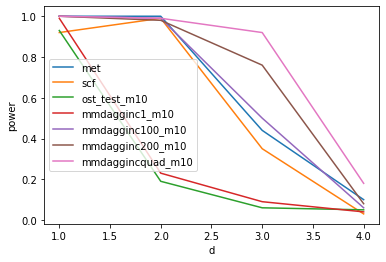

In [6]:
power = mmd_vary_d
tests_names = names_mmd_vary_d
x_axis = x_axis_mmd_vary_d
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("power")
print(power)

## MMD vary mult

In [19]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
d = 1
N = 1000
rep = 100

tests_mmd_vary_mult = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_mult = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_mult

mult_values = [1, 2, 3, 4, 5]
x_axis_mmd_vary_mult = mult_values
outputs_mmd_vary_mult = np.zeros((len(tests), len(mult_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(mult_values)):
        mult = mult_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_mult[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
print(outputs_mmd_vary_mult)
np.save("results/mmd_vary_mult.npy", outputs_mmd_vary_mult)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
d = 1
N = 1000
rep = 100

tests_mmd_vary_mult = [mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_vary_mult = ["mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_vary_mult

mult_values = [1, 2, 3, 4, 5]
x_axis_mmd_vary_mult = mult_values
outputs_mmd_vary_mult = np.zeros((len(tests), len(mult_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(mult_values)):
        mult = mult_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_mult[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
print(outputs_mmd_vary_mult)
np.save("results/mmd_vary_mult_m10.npy", outputs_mmd_vary_mult)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
d = 1
N = 1000
rep = 100

tests_mmd_vary_mult = [ost_test_m10, ]
tests_names_mmd_vary_mult = ["ost_test_m10", ]
tests = tests_mmd_vary_mult

mult_values = [1, 2, 3, 4, 5]
x_axis_mmd_vary_mult = mult_values
outputs_mmd_vary_mult = np.zeros((len(tests), len(mult_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(mult_values)):
        mult = mult_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_mult[j][r][i] = test(X, Y, seed)
np.save("results/mmd_vary_mult_ost_m10.npy", outputs_mmd_vary_mult)


In [9]:
x = np.load("results/mmd_vary_mult.npy")
mmd_vary_mult_met = np.mean(x, -1)[0]
mmd_vary_mult_scf = np.mean(x, -1)[1]

x = np.load("results/mmd_vary_mult_m10.npy")
mmd_vary_mult_mmdagginc1_m10 = np.mean(x, -1)[0]
mmd_vary_mult_mmdagginc100_m10 = np.mean(x, -1)[1]
mmd_vary_mult_mmdagginc200_m10 = np.mean(x, -1)[2]
mmd_vary_mult_mmdaggincquad_m10 = np.mean(x, -1)[3]

x = np.load("results/mmd_vary_mult_ost_m10.npy")
mmd_vary_mult_ost_m10 = np.mean(x, -1)[0]

mmd_vary_mult = np.array([
    mmd_vary_mult_met,
    mmd_vary_mult_scf,
    mmd_vary_mult_ost_m10,
    mmd_vary_mult_mmdagginc1_m10,
    mmd_vary_mult_mmdagginc100_m10,
    mmd_vary_mult_mmdagginc200_m10,
    mmd_vary_mult_mmdaggincquad_m10,
])

x_axis_mmd_vary_mult = [1, 2, 3, 4, 5]

names_mmd_vary_mult = ["met", "scf", "ost_test_m10", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]

[[1.   0.96 0.54 0.26 0.18]
 [0.93 0.71 0.14 0.02 0.01]
 [0.88 0.13 0.12 0.04 0.03]
 [1.   0.21 0.08 0.07 0.03]
 [1.   1.   0.93 0.54 0.28]
 [1.   1.   0.95 0.66 0.44]
 [1.   1.   0.97 0.81 0.57]]


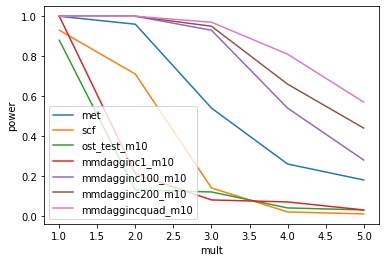

In [10]:
power = mmd_vary_mult
tests_names = names_mmd_vary_mult
x_axis = x_axis_mmd_vary_mult
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("mult")
    plt.ylabel("power")
print(power)

## MMD vary col

In [ ]:
mmdagginc1_col = lambda X, Y, b, seed : agginc("mmd", X, Y, alpha=0.05, R=1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc100_col = lambda X, Y, b, seed : agginc("mmd", X, Y, alpha=0.05, R=100, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdagginc200_col = lambda X, Y, b, seed : agginc("mmd", X, Y, alpha=0.05, R=200, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
mmdaggincquad_col = lambda X, Y, b, seed : agginc("mmd", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1
d = 3

tests_mmd_vary_col = [mmdagginc1_col, mmdagginc100_col, mmdagginc200_col, mmdaggincquad_col]
tests_names_mmd_vary_col = ["mmdagginc1_col", "mmdagginc100_col", "mmdagginc200_col", "mmdaggincquad_col"]
tests = tests_mmd_vary_col

b_values = [i for i in range(11)]
outputs_mmd_vary_col = np.zeros((len(tests), len(b_values), rep))
x_axis_mmd_vary_col = b_values
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(b_values)):
        b = b_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, d))
        Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_col[j][r][i] = test(X, Y, b, seed)
np.save("results/mmd_vary_col.npy", outputs_mmd_vary_col)

In [13]:
x = np.load("results/mmd_vary_col.npy")
mmd_vary_col = np.mean(x, -1)

x_axis_mmd_vary_col = [1 + 2 * i for i in range(11)]

names_mmd_vary_col = ["mmdagginc1_col", "mmdagginc100_col", "mmdagginc200_col", "mmdaggincquad_col"]


[[0.05 0.07 0.07 0.08 0.06 0.02 0.04 0.04 0.05 0.03 0.03]
 [0.04 0.38 0.63 0.56 0.57 0.61 0.45 0.53 0.49 0.43 0.5 ]
 [0.07 0.51 0.88 0.75 0.81 0.82 0.69 0.83 0.71 0.74 0.75]
 [0.06 0.85 0.98 1.   0.99 0.99 0.96 0.97 0.94 0.93 0.93]]


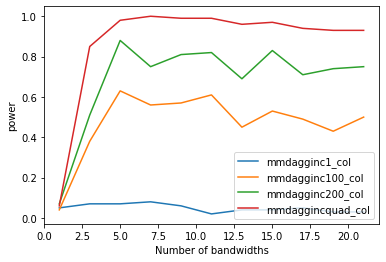

In [15]:
power = mmd_vary_col
tests_names = names_mmd_vary_col
x_axis = x_axis_mmd_vary_col
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("Number of bandwidths")
    plt.ylabel("power")
print(power)

## MMD MNIST

In [ ]:
# run to download mnist dataset
from mnist import download_mnist
download_mnist()

In [ ]:
from mnist import load_mnist
P, Q_list = load_mnist()

In [21]:
%%capture
tests_mmd_mnist_n = [met, scf, ost_test, mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_mnist_n = ["met", "scf", "ost_test", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_mnist_n

Q = Q_list[3]

rep = 100
N_values = [200, 400, 600, 800, 1000]
x_axis_mmd_mnist_n = N_values
outputs_mmd_mnist_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        idx_X = rs.randint(len(P), size=N)
        X = P[idx_X, :]
        idx_Y = rs.randint(len(Q), size=N)
        Y = Q[idx_Y, :]
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_mnist_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
np.save("results/mmd_mnist_n.npy", outputs_mmd_mnist_n)

In [105]:
x = np.load("results/mmd_mnist_n.npy")
mmd_mnist_n = np.mean(x, -1)

x_axis_mmd_mnist_n = [200, 400, 600, 800, 1000]

names_mmd_mnist_n = ["met", "scf", "ost_test", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]


[[0.23 0.41 0.57 0.81 0.89]
 [0.14 0.24 0.23 0.3  0.38]
 [0.1  0.05 0.04 0.12 0.04]
 [0.04 0.06 0.05 0.1  0.04]
 [0.2  0.42 0.61 0.66 0.77]
 [0.24 0.54 0.8  0.85 0.95]
 [0.24 0.62 0.89 0.98 1.  ]]


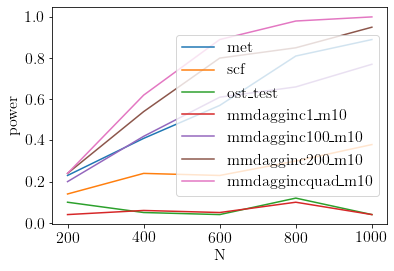

In [106]:
power = mmd_mnist_n
tests_names = names_mmd_mnist_n
x_axis = x_axis_mmd_mnist_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("N")
    plt.ylabel("power")
print(power)

In [23]:
%%capture
tests_mmd_mnist_q = [met, scf, ost_test, mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_mnist_q = ["met", "scf", "ost_test", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_mnist_q

N = 500
rep = 100
Q_values = Q_list + [P, ]
x_axis_mmd_mnist_q = [i + 1 for i in range(len(Q_values))]
outputs_mmd_mnist_q = np.zeros((len(tests), len(Q_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(Q_values)):
        Q = Q_values[r]
        seed += 1
        idx_X = rs.randint(len(P), size=N)
        X = P[idx_X, :]
        idx_Y = rs.randint(len(Q), size=N)
        Y = Q[idx_Y, :]
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_mnist_q[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
np.save("results/mmd_mnist_q.npy", outputs_mmd_mnist_q)

In [17]:
x = np.load("results/mmd_mnist_q.npy")
mmd_mnist_q = np.mean(x, -1)

x_axis_mmd_mnist_q = ["Q1", "Q2", "Q3", "Q4", "Q5", "P"]

names_mmd_mnist_q = ["met", "scf", "ost_test", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]

[[1.   1.   0.83 0.49 0.21 0.08]
 [0.91 0.71 0.37 0.23 0.08 0.05]
 [0.17 0.04 0.07 0.09 0.08 0.08]
 [0.41 0.15 0.08 0.03 0.03 0.05]
 [1.   1.   0.9  0.51 0.1  0.05]
 [1.   1.   0.99 0.7  0.12 0.05]
 [1.   1.   0.99 0.75 0.13 0.05]]


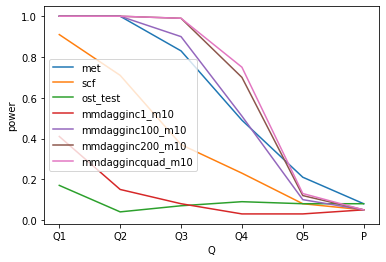

In [18]:
power = mmd_mnist_q
tests_names = names_mmd_mnist_q
x_axis = x_axis_mmd_mnist_q
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("power")
print(power)

# HSIC

In [7]:
hsicagginc1 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=1, l_minus=-2, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc100 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=100, l_minus=-2, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc200 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=200, l_minus=-2, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicaggincquad = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-2, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

hsicagginc1_m2 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=1, l_minus=-2, l_plus=2, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc100_m2 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=100, l_minus=-2, l_plus=2, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc200_m2 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=200, l_minus=-2, l_plus=2, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicaggincquad_m2 = lambda X, Y, seed : agginc("hsic", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-2, l_plus=2, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

## HSIC vary N

In [74]:
%%capture
f_theta_seed = 0
p = 2 
s = 1 # useless with our scaling
d = 2 # dx = 1 and dy = 1
rep = 100
mult = 2 

tests_hsic_vary_n = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_n = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_hsic_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_hsic_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        X = np.expand_dims(Z[:, 0], 1)
        Y = np.expand_dims(Z[:, 1], 1)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/hsic_vary_n.npy", outputs_hsic_vary_n)

In [ ]:
%%capture
f_theta_seed = 0
p = 2 
s = 1 # useless with our scaling
d = 2 # dx = 1 and dy = 1
rep = 100
mult = 2 

tests_hsic_vary_n = [hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_vary_n = ["hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_hsic_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_hsic_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        X = np.expand_dims(Z[:, 0], 1)
        Y = np.expand_dims(Z[:, 1], 1)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/hsic_vary_n_m2.npy", outputs_hsic_vary_n_final)

In [19]:
x = np.load("results/hsic_vary_n.npy")
hsic_vary_n_nfsic = np.mean(x, -1)[0]

x = np.load("results/hsic_vary_n_m2.npy")
hsic_vary_n_hsicagginc1_m2 = np.mean(x, -1)[0]
hsic_vary_n_hsicagginc100_m2 = np.mean(x, -1)[1]
hsic_vary_n_hsicagginc200_m2 = np.mean(x, -1)[2]
hsic_vary_n_hsicaggincquad_m2 = np.mean(x, -1)[3]

hsic_vary_n = np.array([
    hsic_vary_n_nfsic,
    hsic_vary_n_hsicagginc1_m2,
    hsic_vary_n_hsicagginc100_m2,
    hsic_vary_n_hsicagginc200_m2,
    hsic_vary_n_hsicaggincquad_m2,
])

x_axis_hsic_vary_n = [200, 400, 600, 800, 1000]

names_hsic_vary_n = ["fsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]


[[0.1  0.17 0.21 0.29 0.43]
 [0.03 0.05 0.03 0.04 0.02]
 [0.07 0.17 0.3  0.4  0.38]
 [0.08 0.23 0.32 0.47 0.6 ]
 [0.08 0.23 0.37 0.59 0.75]]


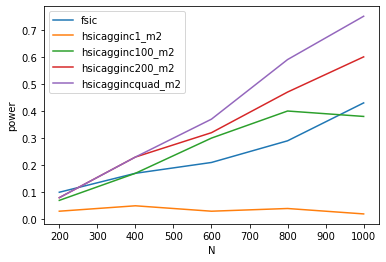

In [20]:
power = hsic_vary_n
tests_names = names_hsic_vary_n
x_axis = x_axis_hsic_vary_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("N")
    plt.ylabel("power")
print(power) 

## HSIC vary d

In [72]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1

tests_hsic_vary_d = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_d = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_d

d_values = [1, 2, 3, 4] # this is dx = 1 and dy = 1, 2, 3, 4
x_axis_hsic_vary_d = d_values
outputs_hsic_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d +1)
        X = Z[:, :1]
        Y = Z[:, 1:]
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/hsic_vary_d.npy", outputs_hsic_vary_d)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 1000
mult = 1

tests_hsic_vary_d = [nfsic, hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_vary_d = ["nfsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_vary_d

d_values = [1, 2, 3, 4] # this is dx = 1 and dy = 1, 2, 3, 4
x_axis_hsic_vary_d = d_values
outputs_hsic_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d + 1) * p ** s / mult 
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d + 1)
        X = Z[:, :1]
        Y = Z[:, 1:]
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/hsic_vary_d_m2_dp1.npy", outputs_hsic_vary_d)

In [23]:
x = np.load("results/hsic_vary_d_m2_dp1.npy")
hsic_vary_d = np.mean(x, -1)

x_axis_hsic_vary_d = np.array([1, 2, 3, 4]) +1

names_hsic_vary_d = ["fsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]


[[1.   0.85 0.16 0.05]
 [0.62 0.04 0.06 0.01]
 [1.   0.97 0.19 0.06]
 [1.   0.99 0.31 0.01]
 [1.   1.   0.4  0.03]]


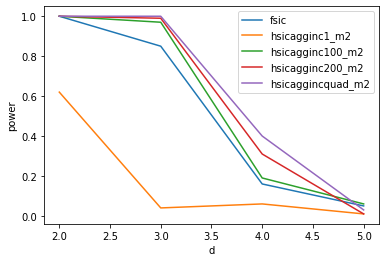

In [24]:
power = hsic_vary_d
tests_names = names_hsic_vary_d
x_axis = x_axis_hsic_vary_d
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("power")
print(power) 

## HSIC vary mult

In [78]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
d = 2 # dx = dy = 1
N = 1000
rep = 100

tests_hsic_vary_mult = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_mult = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_mult

mult_values = [1, 2, 3, 4, 5]
x_axis_hsic_vary_mult = mult_values
outputs_hsic_vary_mult = np.zeros((len(tests), len(mult_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(mult_values)):
        mult = mult_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        X = np.expand_dims(Z[:, 0], 1)
        Y = np.expand_dims(Z[:, 1], 1)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_mult[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
print(outputs_hsic_vary_mult)
np.save("results/hsic_vary_mult.npy", outputs_hsic_vary_mult)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
d = 2 # dx = dy = 1
N = 1000
rep = 100

tests_hsic_vary_mult = [hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_vary_mult = ["hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_vary_mult

mult_values = [1, 2, 3, 4, 5]
x_axis_hsic_vary_mult = mult_values
outputs_hsic_vary_mult = np.zeros((len(tests), len(mult_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(mult_values)):
        mult = mult_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        X = np.expand_dims(Z[:, 0], 1)
        Y = np.expand_dims(Z[:, 1], 1)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_mult[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
print(outputs_hsic_vary_mult)
np.save("results/hsic_vary_mult_m2.npy", outputs_hsic_vary_mult)

In [25]:
x = np.load("results/hsic_vary_mult.npy")
hsic_vary_mult_nfsic = np.mean(x, -1)[0]

x = np.load("results/hsic_vary_mult_m2.npy")
hsic_vary_mult_hsicagginc1_m2 = np.mean(x, -1)[0]
hsic_vary_mult_hsicagginc100_m2 = np.mean(x, -1)[1]
hsic_vary_mult_hsicagginc200_m2 = np.mean(x, -1)[2]
hsic_vary_mult_hsicaggincquad_m2 = np.mean(x, -1)[3]

hsic_vary_mult = np.array([
    hsic_vary_mult_nfsic,
    hsic_vary_mult_hsicagginc1_m2,
    hsic_vary_mult_hsicagginc100_m2,
    hsic_vary_mult_hsicagginc200_m2,
    hsic_vary_mult_hsicaggincquad_m2,
])

x_axis_hsic_vary_mult = [1, 2, 3, 4, 5]

names_hsic_vary_mult = ["fsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]



[[1.   0.67 0.22 0.12 0.11]
 [0.67 0.06 0.13 0.02 0.04]
 [1.   0.97 0.56 0.3  0.19]
 [1.   0.97 0.73 0.35 0.26]
 [0.99 0.99 0.79 0.43 0.3 ]]


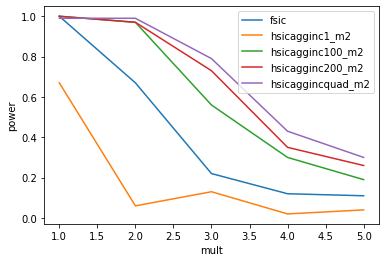

In [26]:
power = hsic_vary_mult
tests_names = names_hsic_vary_mult
x_axis = x_axis_hsic_vary_mult
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("mult")
    plt.ylabel("power")
print(power) 

## HSIC vary col

In [ ]:
hsicagginc1_col = lambda X, Y, b, seed : agginc("hsic", X, Y, alpha=0.05, R=1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc100_col = lambda X, Y, b, seed : agginc("hsic", X, Y, alpha=0.05, R=100, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicagginc200_col = lambda X, Y, b, seed : agginc("hsic", X, Y, alpha=0.05, R=200, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
hsicaggincquad_col = lambda X, Y, b, seed : agginc("hsic", X, Y, alpha=0.05, R=X.shape[0]-1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

In [ ]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 100
N = 600
mult = 1
d = 2

tests_hsic_vary_col = [hsicagginc1_col, hsicagginc100_col, hsicagginc200_col, hsicaggincquad_col]
tests_names_hsic_vary_col = ["hsicagginc1_col", "hsicagginc100_col", "hsicagginc200_col", "hsicaggincquad_col"]
tests = tests_hsic_vary_col

b_values = [i for i in range(6)] 
x_axis_hsic_vary_col = b_values
outputs_hsic_vary_col = np.zeros((len(tests), len(b_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(b_values)):
        b = b_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d + 1) * p ** s / mult 
        Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d + 1)
        X = Z[:, :1]
        Y = Z[:, 1:]
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_col[j][r][i] = test(X, Y, b, seed)
np.save("results/hsic_vary_col.npy", outputs_hsic_vary_col)

In [27]:
x = np.load("results/hsic_vary_col.npy")
hsic_vary_col = np.mean(x, -1)

x_axis_hsic_vary_col = [(1 + 2 * i) ** 2 for i in range(6)] 

names_hsic_vary_col = ["hsicagginc1_col", "hsicagginc100_col", "hsicagginc200_col", "hsicaggincquad_col"]

[[0.08 0.1  0.03 0.05 0.02 0.  ]
 [0.49 0.78 0.77 0.62 0.31 0.03]
 [0.55 0.9  0.86 0.73 0.4  0.07]
 [0.6  0.94 0.9  0.79 0.4  0.07]]


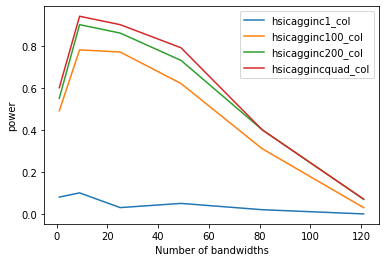

In [29]:
power = hsic_vary_col
tests_names = names_hsic_vary_col
x_axis = x_axis_hsic_vary_col
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("Number of bandwidths")
    plt.ylabel("power")
print(power) 

## HSIC MNIST

In [ ]:
# run to download mnist dataset
from mnist import download_mnist
download_mnist()

In [4]:
import pickle

with open('dataset/mnist.data', 'rb') as handle:
        mnist_dic = pickle.load(handle)

In [5]:
def ind_X_Y_corrupt(seed, N, corrupt_proportion):
    assert corrupt_proportion >= 0
    assert corrupt_proportion <= 1
    max_idx_X = 6000
    idx_Y = rs.randint(10, size=N)
    idx_X = rs.randint(max_idx_X, size=N)
    X = np.array([mnist_dic[str(idx_Y[i])][idx_X[i]] for i in range(N)])
    if corrupt_proportion > 0:
        idx_corrupt = rs.choice([i for i in range(N)], size=int(N * corrupt_proportion), replace=False)
        idx_Y[idx_corrupt] = rs.randint(10, size=int(N * corrupt_proportion))
    Y = np.array(idx_Y.reshape(N, 1), dtype="float64")
    return X, Y
    

In [ ]:
%%capture
tests_hsic_mnist_n = [nfsic, hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_mnist_n = ["nfsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_mnist_n

corrupt_proportion=0.75
rep = 100
N_values = [200, 400, 600, 800, 1000]
x_axis_hsic_mnist_n = N_values
outputs_hsic_mnist_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, Y = ind_X_Y_corrupt(seed, N, corrupt_proportion)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_mnist_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
np.save("results/hsic_mnist_n.npy", outputs_hsic_mnist_n)

In [30]:
x = np.load("results/hsic_mnist_n.npy")
hsic_mnist_n = np.mean(x, -1)

x_axis_hsic_mnist_n = [200, 400, 600, 800, 1000]

names_hsic_mnist_n = ["nfsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]



[[0.1  0.26 0.38 0.55 0.69]
 [0.07 0.04 0.04 0.03 0.05]
 [0.18 0.6  0.8  0.89 0.92]
 [0.18 0.76 0.87 0.95 0.99]
 [0.18 0.76 0.92 0.96 1.  ]]


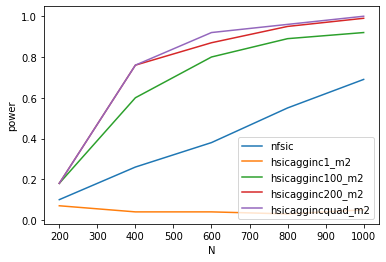

In [31]:
power = hsic_mnist_n
tests_names = names_hsic_mnist_n
x_axis = x_axis_hsic_mnist_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("N")
    plt.ylabel("power")
print(power)

In [ ]:
%%capture
tests_hsic_mnist_c = [nfsic, hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_mnist_c = ["nfsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_mnist_c

N = 500
rep = 100
C_values = [0.6, 0.7, 0.8, 0.9]
x_axis_hsic_mnist_c = C_values
outputs_hsic_mnist_c = np.zeros((len(tests), len(C_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(C_values)):
        corrupt_proportion = C_values[r]
        seed += 1
        X, Y = ind_X_Y_corrupt(seed, N, corrupt_proportion)
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_mnist_c[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
np.save("results/hsic_mnist_c.npy", outputs_hsic_mnist_c)

In [35]:
x = np.load("results/hsic_mnist_c.npy")
hsic_mnist_c = np.mean(x, -1)

x_axis_hsic_mnist_c = [0.6, 0.7, 0.8, 0.9]

names_hsic_mnist_c = ["nfsic", "hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]

[[0.85 0.44 0.11 0.07]
 [0.06 0.09 0.02 0.01]
 [1.   0.92 0.45 0.1 ]
 [1.   0.95 0.56 0.13]
 [1.   0.96 0.59 0.17]]


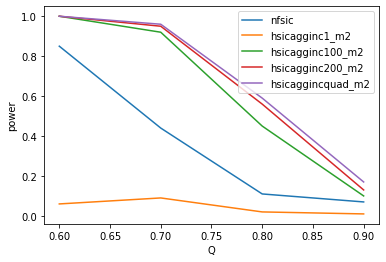

In [36]:
power = hsic_mnist_c
tests_names = names_hsic_mnist_c
x_axis = x_axis_hsic_mnist_c
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("power")
print(power)

# KSD

In [91]:
ksdagginc1 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=1, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc100 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=100, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc200 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=200, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdaggincquad = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=X.shape[0]-1, l_minus=-3, l_plus=0, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

ksdagginc1_m10 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc100_m10 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=100, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc200_m10 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=200, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdaggincquad_m10 = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=X.shape[0]-1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

ksdagginc1_m10s = lambda X, s, seed : agginc("ksd", X, s, alpha=0.05, R=1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc100_m10s = lambda X, s, seed : agginc("ksd", X, s, alpha=0.05, R=100, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdagginc200_m10s = lambda X, s, seed : agginc("ksd", X, s, alpha=0.05, R=200, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
ksdaggincquad_m10s = lambda X, s, seed : agginc("ksd", X, s, alpha=0.05, R=X.shape[0]-1, l_minus=-10, l_plus=10, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)

In [3]:
def generate_rbm(
    seed,
    N,
    sigma,
    dx, # = 50 #50
    dh, # = 40 #40
    burnin_number=2000,
):
    rs = np.random.RandomState(seed)

    # Model p
    B = rs.randint(0, 2, (dx, dh)) * 2 - 1.0
    b = rs.randn(dx)
    c = rs.randn(dh)
    p = kgof_GaussBernRBM(B, b, c)

    # Sample from q
    B_perturbed = B + rs.randn(dx, dh) * sigma
    q = kgof_GaussBernRBM(B_perturbed, b, c)
    ds = q.get_datasource()
    ds.burnin = burnin_number
    samples = ds.sample(N, seed=seed).data()
    
    return samples, p


## KSD vary N

In [101]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [fssd, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad]
tests_names_ksd_vary_n = ["fssd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_n[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/ksd_vary_n.npy", outputs_ksd_vary_n)

In [7]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [ksdagginc1_m10, ksdagginc100_m10, ksdagginc200_m10, ksdaggincquad_m10, L1_IMQ_test]
tests_names_ksd_vary_n = ["ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10", "L1_IMQ_test"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_n[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/ksd_vary_n_m10.npy", outputs_ksd_vary_n)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [rff_cauchy_test, ]
tests_names_ksd_vary_n = ["rff_cauchy_test", ]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_n[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/ksd_vary_n_rff.npy", outputs_ksd_vary_n)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [L1_IMQ_test, ]
tests_names_ksd_vary_n = ["L1_IMQ_test"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_n[j][r][i] = test(X, p, seed, False)
    print(i + 1, "/", rep, "time:", time.time()-t0)  
np.save("results/ksd_vary_n_l1_new.npy", outputs_ksd_vary_n)

In [19]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [lsd_test]
tests_names_ksd_vary_n = ["lsd"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_lsd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
        p = p_dist
        for j in range(len(tests)):
            test = tests[j]
            outputs_lsd_vary_n[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/lsd_vary_n.npy", outputs_lsd_vary_n)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [rff_cauchy_test, L1_IMQ_test]
tests_names_ksd_vary_n = [
    "rff_cauchy_test_n500", 
    "l1_imq_n500", 
]
n_draws = [500, 500]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_n[j][r][i] = test(X, p, seed, n_draw=n_draws[j])
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/ksd_vary_n_rff_l1imq_n500.npy", outputs_ksd_vary_n)

In [ ]:
x = np.load("results/ksd_vary_n.npy")
ksd_vary_n_fssd = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_n_m10.npy")
ksd_vary_n_ksdagginc1_m10 = np.mean(x, -1)[0]
ksd_vary_n_ksdagginc100_m10 = np.mean(x, -1)[1]
ksd_vary_n_ksdagginc200_m10 = np.mean(x, -1)[2]
ksd_vary_n_ksdaggincquad_m10 = np.mean(x, -1)[3]
#ksd_vary_n_l1imq = np.mean(x, -1)[4]

#x = np.load("results/ksd_vary_n_rff.npy")
#ksd_vary_n_rff = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_n_rff_l1imq_n500.npy")
ksd_vary_n_rff = np.mean(x, -1)[0]
ksd_vary_n_l1imq = np.mean(x, -1)[1]

x = np.load("results/lsd_vary_n.npy")
ksd_vary_n_lsd = np.mean(x, -1)[0]

ksd_vary_n = np.array([
    ksd_vary_n_fssd,
    ksd_vary_n_lsd,
    ksd_vary_n_l1imq,
    ksd_vary_n_rff,
    ksd_vary_n_ksdagginc1_m10,
    ksd_vary_n_ksdagginc100_m10,
    ksd_vary_n_ksdagginc200_m10,
    ksd_vary_n_ksdaggincquad_m10,
])

x_axis_ksd_vary_n = [200, 400, 600, 800, 1000]

names_ksd_vary_n = ["fssd", "lsd", "l1_imq", "cauchy_rff", "ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]



[[0.07 0.13 0.25 0.21 0.5 ]
 [0.16 0.19 0.32 0.43 0.54]
 [0.03 0.08 0.13 0.22 0.37]
 [0.09 0.48 0.64 0.73 0.85]
 [0.06 0.01 0.05 0.09 0.07]
 [0.17 0.42 0.51 0.56 0.73]
 [0.18 0.51 0.63 0.72 0.85]
 [0.18 0.64 0.88 0.88 1.  ]]


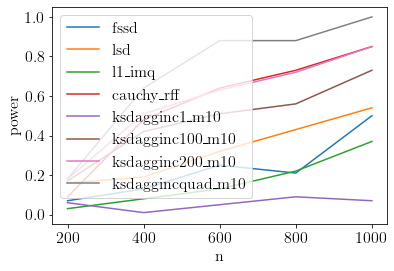

In [129]:
power = ksd_vary_n
tests_names = names_ksd_vary_n
x_axis = x_axis_ksd_vary_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

In [ ]:
names_ksd_vary_n_draws = ["L1IMQ 5000", "Cauchy RFF 5000",  r"KSDAggInc $R=200$", "L1IMQ 500", "Cauchy RFF 500"]

ksd_vary_n_draws = np.array([
    np.mean(np.load("results/ksd_vary_n_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_n_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_n_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_n_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_n_rff_l1imq_n500.npy"),-1)[0],
])

[[0.03 0.12 0.17 0.23 0.41]
 [0.16 0.53 0.68 0.76 0.91]
 [0.18 0.51 0.63 0.72 0.85]
 [0.03 0.08 0.13 0.22 0.37]
 [0.09 0.48 0.64 0.73 0.85]]


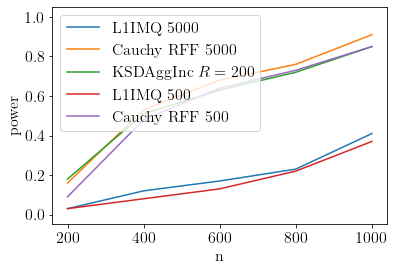

In [130]:
power = ksd_vary_n_draws
tests_names = names_ksd_vary_n_draws
x_axis = x_axis_ksd_vary_n
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

## KSD vary d

In [131]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100
dx = 100

tests_ksd_vary_d = [fssd, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad]
tests_names_ksd_vary_d = ["fssd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad"]
tests = tests_ksd_vary_d

dx_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dx_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dx_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_d[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_d.npy", outputs_ksd_vary_d)

In [8]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100
dx = 100

tests_ksd_vary_d = [ksdagginc1_m10, ksdagginc100_m10, ksdagginc200_m10, ksdaggincquad_m10, L1_IMQ_test]
tests_names_ksd_vary_d = ["ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10", "L1_IMQ_test"]
tests = tests_ksd_vary_d

dh_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dh_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dh_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_d[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_d_m10.npy", outputs_ksd_vary_d)

In [ ]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100
dx = 100

tests_ksd_vary_d = [rff_cauchy_test, ]
tests_names_ksd_vary_d = ["rff_cauchy_test", ]
tests = tests_ksd_vary_d

dh_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dh_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dh_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_d[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_d_rff.npy", outputs_ksd_vary_d)

In [ ]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100

dx = 100

tests_ksd_vary_d = [L1_IMQ_test, ]
tests_names_ksd_vary_d = ["L1_IMQ_test", ]
tests = tests_ksd_vary_d

dh_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dh_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dh_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_d[j][r][i] = test(X, p, seed, False)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_d_l1_new.npy", outputs_ksd_vary_d)

In [18]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100
dx = 100

tests_ksd_vary_d = [lsd_test]
tests_names_ksd_vary_d = ["lsd"]
tests = tests_ksd_vary_d

dh_values = [20, 40, 60, 80]
outputs_lsd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dh_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dh_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
        p = p_dist
        for j in range(len(tests)):
            test = tests[j]
            outputs_lsd_vary_d[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/lsd_vary_d.npy", outputs_lsd_vary_d)


In [ ]:
%%capture 
sigma = 0.03 
N = 1000
rep = 100
dx = 100

tests_ksd_vary_d = [rff_cauchy_test, L1_IMQ_test] 
tests_names_ksd_vary_d = [
    "rff_cauchy_test_n500", 
    "l1imq_test_n500", 
]
n_draws = [500, 500]
tests = tests_ksd_vary_d

dh_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dh_values), rep))
x_axis_ksd_vary_d = dh_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dh_values)):
        dh = dh_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_d[j][r][i] = test(X, p, seed, n_draw=n_draws[j])
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_d_rff_l1imq_n500.npy", outputs_ksd_vary_d)

In [ ]:
x = np.load("results/ksd_vary_d.npy")
ksd_vary_d_fssd = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_d_m10.npy")
ksd_vary_d_ksdagginc1_m10 = np.mean(x, -1)[0]
ksd_vary_d_ksdagginc100_m10 = np.mean(x, -1)[1]
ksd_vary_d_ksdagginc200_m10 = np.mean(x, -1)[2]
ksd_vary_d_ksdaggincquad_m10 = np.mean(x, -1)[3]
#ksd_vary_d_l1imq = np.mean(x, -1)[4]

#x = np.load("results/ksd_vary_d_rff.npy")
#ksd_vary_d_rff = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_d_rff_l1imq_n500.npy")
ksd_vary_d_rff = np.mean(x, -1)[0]
ksd_vary_d_l1imq = np.mean(x, -1)[1]

x = np.load("results/lsd_vary_d.npy")
ksd_vary_d_lsd = np.mean(x, -1)[0]

ksd_vary_d = np.array([
    ksd_vary_d_fssd,
    ksd_vary_d_lsd,
    ksd_vary_d_l1imq,
    ksd_vary_d_rff,
    ksd_vary_d_ksdagginc1_m10,
    ksd_vary_d_ksdagginc100_m10,
    ksd_vary_d_ksdagginc200_m10,
    ksd_vary_d_ksdaggincquad_m10,
])

x_axis_ksd_vary_d = [20, 40, 60, 80]

names_ksd_vary_d = ["fssd", "lsd", "l1_imq", "cauchy_rff", "ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]


[[0.31 0.5  0.63 0.65]
 [0.72 0.97 0.99 1.  ]
 [0.35 0.5  0.73 0.68]
 [0.88 0.95 0.99 1.  ]
 [0.08 0.1  0.14 0.08]
 [0.66 0.93 0.99 1.  ]
 [0.79 1.   1.   1.  ]
 [0.98 1.   1.   1.  ]]


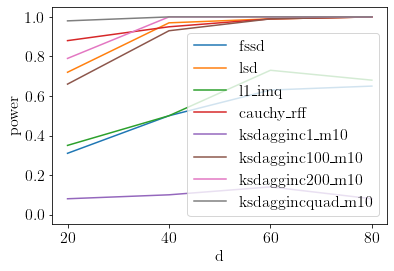

In [140]:
power = ksd_vary_d
tests_names = names_ksd_vary_d
x_axis = x_axis_ksd_vary_d
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

In [ ]:
names_ksd_vary_d_draws = ["L1IMQ 5000", "Cauchy RFF 5000",  r"KSDAggInc $R=200$", "L1IMQ 500", "Cauchy RFF 500"]

ksd_vary_d_draws = np.array([
    np.mean(np.load("results/ksd_vary_d_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_d_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_d_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_d_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_d_rff_l1imq_n500.npy"),-1)[0],
])

[[0.4  0.57 0.79 0.79]
 [0.92 0.99 1.   1.  ]
 [0.79 1.   1.   1.  ]
 [0.35 0.5  0.73 0.68]
 [0.88 0.95 0.99 1.  ]]


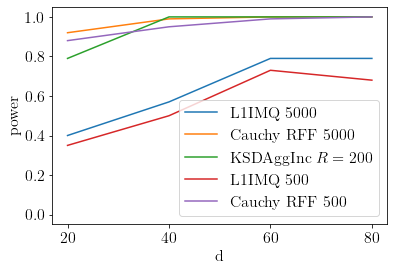

In [141]:
power = ksd_vary_d_draws
tests_names = names_ksd_vary_d_draws
x_axis = x_axis_ksd_vary_d
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

## KSD vary sigma

In [122]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [fssd, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad]
tests_names_ksd_vary_sigma = ["fssd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad"]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_ksd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_sigma[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_sigma.npy", outputs_ksd_vary_sigma)

In [9]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [ksdagginc1_m10, ksdagginc100_m10, ksdagginc200_m10, ksdaggincquad_m10, L1_IMQ_test]
tests_names_ksd_vary_sigma = ["ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10", "L1_IMQ_test"]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_ksd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_sigma[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_sigma_m10.npy", outputs_ksd_vary_sigma)

In [ ]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [L1_IMQ_test, ]
tests_names_ksd_vary_sigma = ["L1_IMQ_test", ]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_ksd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_sigma[j][r][i] = test(X, p, seed, False)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/ksd_vary_sigma_l1_new.npy", outputs_ksd_vary_sigma)

In [ ]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [rff_cauchy_test, ]
tests_names_ksd_vary_sigma = ["rff_cauchy_test", ]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_ksd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_sigma[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_sigma_rff.npy", outputs_ksd_vary_sigma)

In [14]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [lsd_test]
tests_names_ksd_vary_sigma = ["lsd"]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_lsd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
        p = p_dist
        for j in range(len(tests)):
            test = tests[j]
            outputs_lsd_vary_sigma[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/lsd_vary_sigma.npy", outputs_lsd_vary_sigma)

In [ ]:
%%capture 
dx = 50
dh = 40
N = 1000
rep = 100

tests_ksd_vary_sigma = [rff_cauchy_test, L1_IMQ_test] 
tests_names_ksd_vary_sigma = [
    "rff_cauchy_test_n500",  
    "l1_imq_test_n500",
]
n_draws = [500, 500]
tests = tests_ksd_vary_sigma

sigma_values = [0, 0.01, 0.02, 0.03, 0.04]
outputs_ksd_vary_sigma = np.zeros((len(tests), len(sigma_values), rep))
x_axis_ksd_vary_sigma = sigma_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(sigma_values)):
        sigma = sigma_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_sigma[j][r][i] = test(X, p, seed, n_draw=n_draws[j])
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/ksd_vary_sigma_rff_l1imq_n500.npy", outputs_ksd_vary_sigma)

In [ ]:
x = np.load("results/ksd_vary_sigma.npy")
ksd_vary_sigma_fssd = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_sigma_m10.npy")
ksd_vary_sigma_ksdagginc1_m10 = np.mean(x, -1)[0]
ksd_vary_sigma_ksdagginc100_m10 = np.mean(x, -1)[1]
ksd_vary_sigma_ksdagginc200_m10 = np.mean(x, -1)[2]
ksd_vary_sigma_ksdaggincquad_m10 = np.mean(x, -1)[3]
#ksd_vary_sigma_l1imq = np.mean(x, -1)[4]

#x = np.load("results/ksd_vary_sigma_rff.npy")
#ksd_vary_sigma_rff = np.mean(x, -1)[0]

x = np.load("results/ksd_vary_sigma_rff_l1imq_n500.npy")
ksd_vary_sigma_rff = np.mean(x, -1)[0]
ksd_vary_sigma_l1imq = np.mean(x, -1)[1]

x = np.load("results/lsd_vary_sigma.npy")
ksd_vary_sigma_lsd = np.mean(x, -1)[0]

ksd_vary_sigma = np.array([
    ksd_vary_sigma_fssd,
    ksd_vary_sigma_lsd,
    ksd_vary_sigma_l1imq,
    ksd_vary_sigma_rff,
    ksd_vary_sigma_ksdagginc1_m10,
    ksd_vary_sigma_ksdagginc100_m10,
    ksd_vary_sigma_ksdagginc200_m10,
    ksd_vary_sigma_ksdaggincquad_m10,
])

x_axis_ksd_vary_sigma = [0, 0.01, 0.02, 0.03, 0.04]

names_ksd_vary_sigma = ["fssd", "lsd", "l1_imq", "cauchy_rff", "ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]


[[0.02 0.09 0.48 0.71 0.99]
 [0.03 0.1  0.61 0.96 1.  ]
 [0.   0.02 0.3  0.71 0.96]
 [0.02 0.19 0.86 0.97 1.  ]
 [0.09 0.03 0.07 0.1  0.25]
 [0.04 0.14 0.68 0.99 1.  ]
 [0.06 0.19 0.9  1.   1.  ]
 [0.06 0.27 1.   1.   1.  ]]


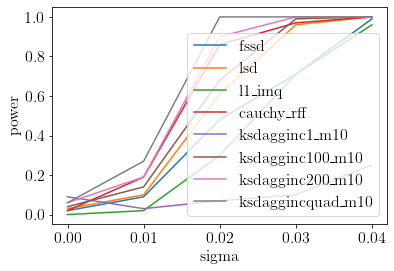

In [138]:
power = ksd_vary_sigma
tests_names = names_ksd_vary_sigma
x_axis = x_axis_ksd_vary_sigma
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("sigma")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

In [ ]:
names_ksd_vary_sigma_draws = ["L1IMQ 5000", "Cauchy RFF 5000",  r"KSDAggInc $R=200$", "L1IMQ 500", "Cauchy RFF 500"]

ksd_vary_sigma_draws = np.array([
    np.mean(np.load("results/ksd_vary_sigma_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_sigma_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_sigma_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_sigma_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_sigma_rff_l1imq_n500.npy"),-1)[0],
])

[[0.01 0.02 0.33 0.71 0.96]
 [0.04 0.25 0.89 0.97 1.  ]
 [0.06 0.19 0.9  1.   1.  ]
 [0.   0.02 0.3  0.71 0.96]
 [0.02 0.19 0.86 0.97 1.  ]]


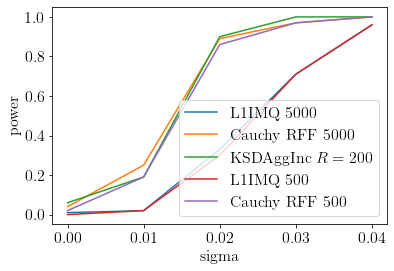

In [139]:
power = ksd_vary_sigma_draws
tests_names = names_ksd_vary_sigma_draws
x_axis = x_axis_ksd_vary_sigma
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("sigma")
    plt.ylabel("power")
    plt.ylim(-0.05,1.05)
print(power) 

## KSD vary col

In [ ]:
rbm_ksdagginc1_col = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
rbm_ksdagginc100_col = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=100, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
rbm_ksdagginc200_col = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=200, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)
rbm_ksdaggincquad_col = lambda X, p, seed : agginc("ksd", X, p.grad_log(X), alpha=0.05, R=X.shape[0]-1, l_minus=-b, l_plus=b, B1=500, B2=500, B3=50, weights_type="uniform", seed=seed)


In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100
N = 400

tests_ksd_vary_col = [ksdagginc1_col, ksdagginc100_col, ksdagginc200_col, ksdaggincquad_col]
tests_names_ksd_vary_col = ["ksdagginc1_col", "ksdagginc100_col", "ksdagginc200_col", "ksdaggincquad_col"]
tests = tests_ksd_vary_col

b_values = [i for i in range(16)]
outputs_ksd_vary_col = np.zeros((len(tests), len(b_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_col = b_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(b_values)):
        b = b_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        )
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_vary_col[j][r][i] = test(X, p, seed)
np.save("results/ksd_vary_col.npy", outputs_ksd_vary_col)

In [ ]:
x = np.load("results/ksd_vary_col.npy")
ksd_vary_col = np.mean(x, -1)

x_axis_ksd_vary_col = [1 + 2 * i for i in range(16)]

names_ksd_vary_col = ["ksdagginc1_col", "ksdagginc100_col", "ksdagginc200_col", "ksdaggincquad_col"]



[[0.08 0.04 0.06 0.12 0.06 0.1  0.03 0.05 0.04 0.04 0.07 0.03 0.09 0.05
  0.05 0.07]
 [0.24 0.33 0.32 0.33 0.44 0.36 0.38 0.46 0.4  0.38 0.39 0.32 0.33 0.36
  0.4  0.35]
 [0.38 0.41 0.41 0.52 0.57 0.52 0.48 0.46 0.48 0.43 0.43 0.45 0.57 0.55
  0.55 0.56]
 [0.37 0.45 0.52 0.57 0.58 0.59 0.67 0.59 0.58 0.6  0.55 0.62 0.6  0.58
  0.6  0.58]]


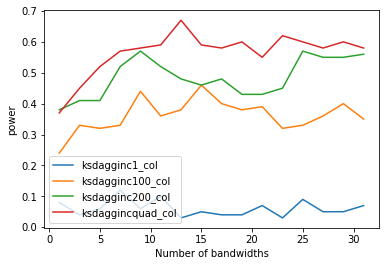

In [45]:
power = ksd_vary_col
tests_names = names_ksd_vary_col
x_axis = x_axis_ksd_vary_col
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("Number of bandwidths")
    plt.ylabel("power")
print(power)

## KSD MNIST

The MNIST samples `X_mnist_power.npy` and score values `score_X_mnist_power` of the MNIST Normalizing Flow can be generated by running the script:
https://github.com/antoninschrab/ksdagg-paper/blob/master/generate_data_nf.py
Alternatively, it can be downloaded by running the script:
https://github.com/antoninschrab/ksdagg-paper/blob/master/download_data.py
It can also be downloaded directly from:
https://drive.google.com/file/d/1CSj36IEW9x5_CCbiNXqBhqVqofiaGE0D/view?usp=sharing

In [63]:
from kgof.density import from_grad_log

# download or generate the data as explained above
X_rep_p = np.load("./NF_MNIST/X_mnist_power.npy").reshape(-1, 784)
score_X_rep_p = np.load("./NF_MNIST/score_X_mnist_power.npy").reshape(-1, 784)

In [ ]:
%%capture
tests_ksd_mnist_p = [ksdagginc1_m10s, ksdagginc100_m10s, ksdagginc200_m10s, ksdaggincquad_m10s]
tests_names_ksd_mnist_p = ["ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]
tests = tests_ksd_mnist_p

rep = 100
N_values = [200, 400, 600, 800, 1000]
x_axis_ksd_mnist_p = N_values
outputs_ksd_mnist_p = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        idx = rs.choice(X_rep_p.shape[0] - 1, size=N, replace=False)
        X = X_rep_p[idx]
        score_X = score_X_rep_p[idx]
        for j in range(len(tests)):
            test = tests[j]
            outputs_ksd_mnist_p[j][r][i] = test(X, score_X, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)
np.save("results/ksd_mnist_p.npy", outputs_ksd_mnist_p)

In [ ]:
x = np.load("results/ksd_mnist_p.npy")
ksd_mnist_p = np.mean(x, -1)

x_axis_ksd_mnist_p = [200, 400, 600, 800, 1000]

names_ksd_mnist_p = ["ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]



[[0.05 0.09 0.04 0.04 0.01]
 [0.21 0.35 0.48 0.58 0.57]
 [0.26 0.59 0.65 0.74 0.82]
 [0.26 0.72 0.79 0.9  0.98]]


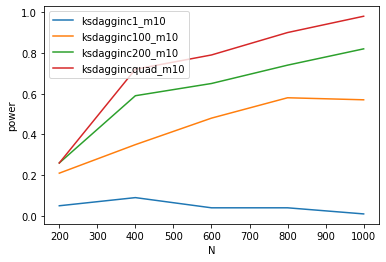

In [48]:
power = ksd_mnist_p
tests_names = names_ksd_mnist_p
x_axis = x_axis_ksd_mnist_p
for j in range(power.shape[0]):
    plt.plot(x_axis, power[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("N")
    plt.ylabel("power")
print(power)

# Time

## MMD vary N Time

In [36]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
mult = 2

tests_mmd_vary_n = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_n = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_mmd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_mmd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    perturbation_multiplier = np.exp(d) * p ** s / mult
    X = rs.uniform(0, 1, (N, d)) 
    Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
    for j in range(len(tests)):
        test = tests[j]
        time_f = %timeit -o -r 20 -n 1 test(X, Y, seed)
        time_mmd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_mmd_vary_n_std[j][r] = np.std(time_f.timings)    
np.save("results/time_mmd_vary_n_mean.npy", time_mmd_vary_n_mean)
np.save("results/time_mmd_vary_n_std.npy", time_mmd_vary_n_std)

In [74]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
mult = 2

tests_mmd_vary_n = [mmdagginc1_m10, mmdagginc100_m10, mmdagginc200_m10, mmdaggincquad_m10]
tests_names_mmd_vary_n = ["mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_mmd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_mmd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    perturbation_multiplier = np.exp(d) * p ** s / mult
    X = rs.uniform(0, 1, (N, d)) 
    Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
    for j in range(len(tests)):
        test = tests[j]
        time_f = %timeit -o -r 20 -n 1 test(X, Y, seed)
        time_mmd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_mmd_vary_n_std[j][r] = np.std(time_f.timings)    
np.save("results/time_mmd_vary_n_mean_m10.npy", time_mmd_vary_n_mean)
np.save("results/time_mmd_vary_n_std_m10.npy", time_mmd_vary_n_std)

In [3]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
mult = 2

tests_mmd_vary_n = [ost_test_m10, ]
tests_names_mmd_vary_n = ["ost_test_m10", ]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_mmd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_mmd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    perturbation_multiplier = np.exp(d) * p ** s / mult
    X = rs.uniform(0, 1, (N, d)) 
    Y = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
    for j in range(len(tests)):
        test = tests[j]
        time_f = %timeit -o -r 20 -n 1 test(X, Y, seed)
        time_mmd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_mmd_vary_n_std[j][r] = np.std(time_f.timings)    
np.save("results/time_mmd_vary_n_mean_ost_m10.npy", time_mmd_vary_n_mean)
np.save("results/time_mmd_vary_n_std_ost_m10.npy", time_mmd_vary_n_std)

In [57]:
m = np.load("results/time_mmd_vary_n_mean.npy")
s = np.load("results/time_mmd_vary_n_std.npy")
mmd_time_mean_met = m[0]
mmd_time_std_met = s[0]
mmd_time_mean_scf = m[1]
mmd_time_std_scf = s[1]

m = np.load("results/time_mmd_vary_n_mean_m10.npy")
s = np.load("results/time_mmd_vary_n_std_m10.npy")
mmd_time_mean_mmdagginc1_m10 = m[0]
mmd_time_std_mmdagginc1_m10 = s[0]
mmd_time_mean_mmdagginc100_m10 = m[1]
mmd_time_std_mmdagginc100_m10 = s[1]
mmd_time_mean_mmdagginc200_m10 = m[2]
mmd_time_std_mmdagginc200_m10 = s[2]
mmd_time_mean_mmdaggincquad_m10 = m[3]
mmd_time_std_mmdaggincquad_m10 = s[3]

m = np.load("results/time_mmd_vary_n_mean_ost_m10.npy")
s = np.load("results/time_mmd_vary_n_std_ost_m10.npy")
mmd_time_mean_ost_m10 = m[0]
mmd_time_std_ost_m10 = s[0]

mmd_time_mean = np.array([
    mmd_time_mean_met,
    mmd_time_mean_scf,
    mmd_time_mean_ost_m10,
    mmd_time_mean_mmdagginc1_m10,
    mmd_time_mean_mmdagginc100_m10,
    mmd_time_mean_mmdagginc200_m10,
    mmd_time_mean_mmdaggincquad_m10,
])

mmd_time_std = np.array([
    mmd_time_std_met,
    mmd_time_std_scf,
    mmd_time_std_ost_m10,
    mmd_time_std_mmdagginc1_m10,
    mmd_time_std_mmdagginc100_m10,
    mmd_time_std_mmdagginc200_m10,
    mmd_time_std_mmdaggincquad_m10,
])

x_axis_mmd_time = [200, 400, 600, 800, 1000]

names_mmd_time = ["met", "scf", "ost_test_m10", "mmdagginc1_m10", "mmdagginc100_m10", "mmdagginc200_m10", "mmdaggincquad_m10"]



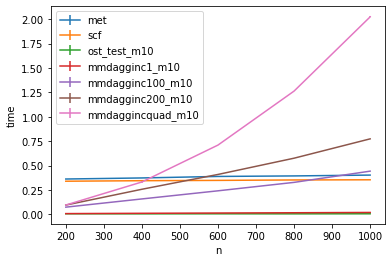

In [59]:
time_mean = mmd_time_mean
time_std = mmd_time_std
tests_names = names_mmd_time
x_axis = x_axis_mmd_time
for j in range(len(tests_names)):
    plt.errorbar(x_axis, time_mean[j], time_std[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("time")

## HSIC vary N Time

In [44]:
%%capture
f_theta_seed = 0
p = 2 
s = 1 # useless with our scaling
d = 2 # dx = 1 and dy = 1
rep = 100
mult = 2 

tests_hsic_vary_n = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_n = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_n

N_values = [200, 400, 600, 800, 1000]
time_hsic_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_hsic_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_hsic_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    perturbation_multiplier = np.exp(d) * p ** s / mult
    Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
    X = np.expand_dims(Z[:, 0], 1)
    Y = np.expand_dims(Z[:, 1], 1)
    for j in range(len(tests)):
        test = tests[j]
        time_f = %timeit -o -r 20 -n 1 test(X, Y, seed)
        time_hsic_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_hsic_vary_n_std[j][r] = np.std(time_f.timings)    
np.save("results/time_hsic_vary_n_mean.npy", time_hsic_vary_n_mean)
np.save("results/time_hsic_vary_n_std.npy", time_hsic_vary_n_std)

In [75]:
%%capture
f_theta_seed = 0
p = 2 
s = 1 # useless with our scaling
d = 2 # dx = 1 and dy = 1
rep = 100
mult = 2 

tests_hsic_vary_n = [hsicagginc1_m2, hsicagginc100_m2, hsicagginc200_m2, hsicaggincquad_m2]
tests_names_hsic_vary_n = ["hsicagginc1_m2", "hsicagginc100_m2", "hsicagginc200_m2", "hsicaggincquad_m2"]
tests = tests_hsic_vary_n

N_values = [200, 400, 600, 800, 1000]
time_hsic_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_hsic_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_hsic_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    perturbation_multiplier = np.exp(d) * p ** s / mult
    Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
    X = np.expand_dims(Z[:, 0], 1)
    Y = np.expand_dims(Z[:, 1], 1)
    for j in range(len(tests)):
        test = tests[j]
        time_f = %timeit -o -r 20 -n 1 test(X, Y, seed)
        time_hsic_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_hsic_vary_n_std[j][r] = np.std(time_f.timings)    
np.save("results/time_hsic_vary_n_mean_m2.npy", time_hsic_vary_n_mean)
np.save("results/time_hsic_vary_n_std_m2.npy", time_hsic_vary_n_std)

In [60]:
m = np.load("results/time_hsic_vary_n_mean.npy")
s = np.load("results/time_hsic_vary_n_std.npy")
hsic_time_mean_nfsic = m[0]
hsic_time_std_nfsic = s[0]

m = np.load("results/time_hsic_vary_n_mean_m2.npy")
s = np.load("results/time_hsic_vary_n_std_m2.npy")
hsic_time_mean_hsicagginc1_m10 = m[0]
hsic_time_std_hsicagginc1_m10 = s[0]
hsic_time_mean_hsicagginc100_m10 = m[1]
hsic_time_std_hsicagginc100_m10 = s[1]
hsic_time_mean_hsicagginc200_m10 = m[2]
hsic_time_std_hsicagginc200_m10 = s[2]
hsic_time_mean_hsicaggincquad_m10 = m[3]
hsic_time_std_hsicaggincquad_m10 = s[3]

hsic_time_mean = np.array([
    hsic_time_mean_nfsic,
    hsic_time_mean_hsicagginc1_m10,
    hsic_time_mean_hsicagginc100_m10,
    hsic_time_mean_hsicagginc200_m10,
    hsic_time_mean_hsicaggincquad_m10,
])

hsic_time_std = np.array([
    hsic_time_std_nfsic,
    hsic_time_std_hsicagginc1_m10,
    hsic_time_std_hsicagginc100_m10,
    hsic_time_std_hsicagginc200_m10,
    hsic_time_std_hsicaggincquad_m10,
])

x_axis_hsic_time = [200, 400, 600, 800, 1000]

names_hsic_time = ["nfsic", "hsicagginc1_m10", "hsicagginc100_m10", "hsicagginc200_m10", "hsicaggincquad_m10"]




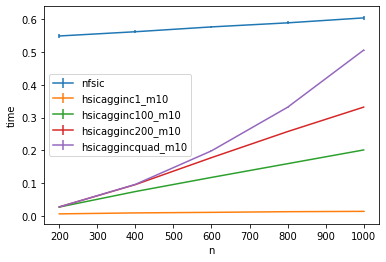

In [61]:
time_mean = hsic_time_mean
time_std = hsic_time_std
tests_names = names_hsic_time
x_axis = x_axis_mmd_time
for j in range(len(tests_names)):
    plt.errorbar(x_axis, time_mean[j], time_std[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("time")

## KSD vary N Time

In [42]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [fssd, lsd_test, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad]
tests_names_ksd_vary_n = ["fssd", "lsd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_ksd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_ksd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    X, p = generate_rbm(
        seed,
        N,
        sigma,
        dx, 
        dh,
    ) 
    for j in range(len(tests)):
        test = tests[j]
        if test == lsd_test:
            p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
            time_f = %timeit -o -r 20 -n 1 test(X, p_dist, seed)
        else:
            time_f = %timeit -o -r 20 -n 1 test(X, p, seed)
        time_ksd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_ksd_vary_n_std[j][r] = np.std(time_f.timings)  
        
np.save("results/time_ksd_vary_n_mean.npy", time_ksd_vary_n_mean)
np.save("results/time_ksd_vary_n_std.npy", time_ksd_vary_n_std)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [L1_IMQ_test, ksdagginc1_m10, ksdagginc100_m10, ksdagginc200_m10, ksdaggincquad_m10]
tests_names_ksd_vary_n = ["L1_IMQ_test", "ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_ksd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_ksd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    seed += 1
    X, p = generate_rbm(
        seed,
        N,
        sigma,
        dx, 
        dh,
    ) 
    for j in range(len(tests)):
        test = tests[j]
        if test == lsd_test:
            p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
            time_f = %timeit -o -r 20 -n 1 test(X, p_dist, seed)
        else:
            time_f = %timeit -o -r 20 -n 1 test(X, p, seed)
        time_ksd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_ksd_vary_n_std[j][r] = np.std(time_f.timings)  
        
np.save("results/time_ksd_vary_n_mean_m10.npy", time_ksd_vary_n_mean)
np.save("results/time_ksd_vary_n_std_m10.npy", time_ksd_vary_n_std)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [rff_cauchy_test, ]
tests_names_ksd_vary_n = ["rff_cauchy_test", ]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_ksd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_ksd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    print(N)
    seed += 1
    X, p = generate_rbm(
        seed,
        N,
        sigma,
        dx, 
        dh,
    ) 
    for j in range(len(tests)):
        test = tests[j]
        if test == lsd_test:
            p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
            time_f = %timeit -o -r 5 -n 1 test(X, p_dist, seed)
        else:
            time_f = %timeit -o -r 5 -n 1 test(X, p, seed)
        time_ksd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_ksd_vary_n_std[j][r] = np.std(time_f.timings)  
        
np.save("results/time_ksd_vary_n_mean_rff.npy", time_ksd_vary_n_mean)
np.save("results/time_ksd_vary_n_std_rff.npy", time_ksd_vary_n_std)

In [ ]:
%%capture
sigma = 0.02
dx = 50
dh = 40
rep = 100

tests_ksd_vary_n = [L1_IMQ_test, L1_IMQ_test, rff_cauchy_test, rff_cauchy_test, ksdagginc200_m10] 
tests_names_ksd_vary_n = [
    "l1_imq_test_n500", 
    "l1_imq_test_n5000", 
    "rff_cauchy_test_n500", 
    "rff_cauchy_test_n5000", 
    "ksdagginc200_m10",
]
n_draws = [500, 5000, 500, 5000]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
time_ksd_vary_n_mean = np.zeros((len(tests), len(N_values)))
time_ksd_vary_n_std = np.zeros((len(tests), len(N_values)))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0

for r in range(len(N_values)):
    N = N_values[r]
    print(N)
    seed += 1
    X, p = generate_rbm(
        seed,
        N,
        sigma,
        dx, 
        dh,
    ) 
    for j in range(len(tests)):
        test = tests[j]
        if j == 4:
            time_f = %timeit -o -r 1 -n 1 test(X, p, seed)
        else:
            time_f = %timeit -o -r 1 -n 1 test(X, p, seed, n_draw=n_draws[j])
        time_ksd_vary_n_mean[j][r] = np.mean(time_f.timings)
        time_ksd_vary_n_std[j][r] = np.std(time_f.timings)  

np.save("results/time_ksd_vary_n_mean_draws.npy", time_ksd_vary_n_mean)
np.save("results/time_ksd_vary_n_std_draws.npy", time_ksd_vary_n_std)

In [ ]:
m = np.load("results/time_ksd_vary_n_mean.npy")
s = np.load("results/time_ksd_vary_n_std.npy")
ksd_time_mean_fssd = m[0]
ksd_time_std_fssd = s[0]
ksd_time_mean_lsd = m[1]
ksd_time_std_lsd = s[1]

m = np.load("results/time_ksd_vary_n_mean_m10.npy")
s = np.load("results/time_ksd_vary_n_std_m10.npy")
#ksd_time_mean_l1_imq = m[0]
#ksd_time_std_l1_imq = s[0]
ksd_time_mean_ksdagginc1_m10 = m[1]
ksd_time_std_ksdagginc1_m10 = s[1]
ksd_time_mean_ksdagginc100_m10 = m[2]
ksd_time_std_ksdagginc100_m10 = s[2]
ksd_time_mean_ksdagginc200_m10 = m[3]
ksd_time_std_ksdagginc200_m10 = s[3]
ksd_time_mean_ksdaggincquad_m10 = m[4]
ksd_time_std_ksdaggincquad_m10 = s[4]

#m = np.load("results/time_ksd_vary_n_mean_rff.npy")
#s = np.load("results/time_ksd_vary_n_std_rff.npy")
#ksd_time_mean_rff = m[0]
#ksd_time_std_rff = s[0]

m = np.load("results/time_ksd_vary_n_mean_draws.npy")
s = np.load("results/time_ksd_vary_n_std_draws.npy")
ksd_time_mean_rff = m[2]
ksd_time_std_rff = s[2]
ksd_time_mean_l1_imq = m[0]
ksd_time_std_l1_imq = s[0]

ksd_time_mean = np.array([
    ksd_time_mean_fssd,
    ksd_time_mean_lsd,
    ksd_time_mean_l1_imq,
    ksd_time_mean_rff,
    ksd_time_mean_ksdagginc1_m10,
    ksd_time_mean_ksdagginc100_m10,
    ksd_time_mean_ksdagginc200_m10,
    ksd_time_mean_ksdaggincquad_m10,
])

ksd_time_std = np.array([
    ksd_time_std_fssd,
    ksd_time_std_lsd,
    ksd_time_std_l1_imq,
    ksd_time_std_rff,
    ksd_time_std_ksdagginc1_m10,
    ksd_time_std_ksdagginc100_m10,
    ksd_time_std_ksdagginc200_m10,
    ksd_time_std_ksdaggincquad_m10,
])


x_axis_ksd_time = [200, 400, 600, 800, 1000]

names_ksd_time = ["fssd", "lsd", "l1_imq", "cauchy_rff", "ksdagginc1_m10", "ksdagginc100_m10", "ksdagginc200_m10", "ksdaggincquad_m10"]


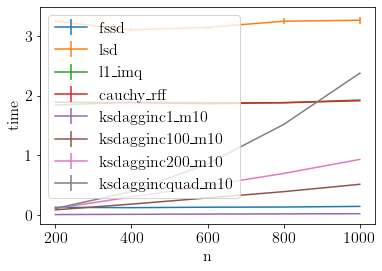

In [143]:
time_mean = ksd_time_mean
time_std = ksd_time_std
tests_names = names_ksd_time
x_axis = x_axis_ksd_time
for j in range(len(tests_names)):
    plt.errorbar(x_axis, time_mean[j], time_std[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("time")

Text(0, 0.5, 'time')

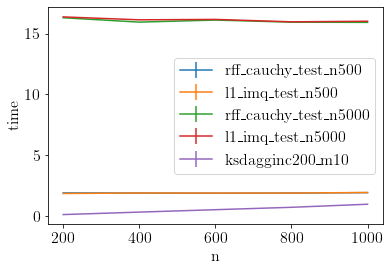

In [144]:
m = np.load("results/time_ksd_vary_n_mean_draws.npy")
s = np.load("results/time_ksd_vary_n_std_draws.npy")
tests_names = [
        "l1_imq_test_n500", 
        "l1_imq_test_n5000", 
        "rff_cauchy_test_n500", 
        "rff_cauchy_test_n5000", 
        "ksdagginc200_m10",
    ]
x_axis = [200, 400, 600, 800, 1000]
for j in [2, 0, 3, 1, 4]:
    plt.errorbar(x_axis, m[j], s[j], label=tests_names[j])
plt.legend()
plt.xlabel("n")
plt.ylabel("time")

# Plots

To run the code to create the plots, the cells loading the data in the previous sections first need to be run.

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams

In [ ]:
fs = 16
rcParams.update({"font.size": fs})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## MMD plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


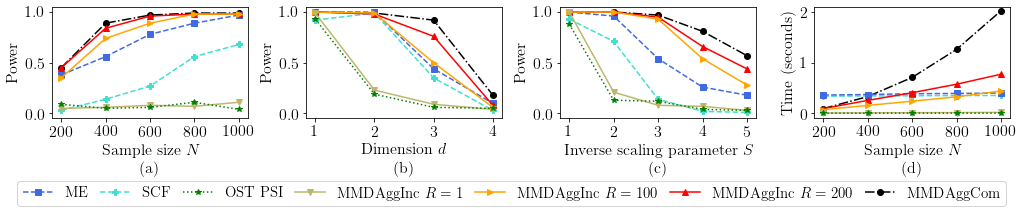

In [138]:
# MMD
scale = 0.8
f, axs = plt.subplots(1, 4, figsize=(18 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = ["ME", "SCF", "OST PSI", r"MMDAggInc $R=1$", r"MMDAggInc $R=100$", r"MMDAggInc $R=200$", r"MMDAggCom"]
styles = ["--", "--", "dotted", "-", "-", "-", "-."]
markers = ["s", "P", "*", "v", ">", "^", "o"]
colors = ["royalblue", "turquoise", "green", "darkkhaki", "orange", "red", "black"]
order = [6, 1, 0, 5, 4, 3, 2]

# Plot 0 MMD vary n
idx = 0
power = mmd_vary_n
x_axis = x_axis_mmd_vary_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (a)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 MMD vary d
idx = 1
power = mmd_vary_d
x_axis = x_axis_mmd_vary_d
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Dimension $d$" + "\n (b)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 2 MMD vary mult
idx = 2
power = mmd_vary_mult
x_axis = x_axis_mmd_vary_mult
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Inverse scaling parameter $S$" + "\n (c)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 3 MMD vary time
idx = 3
time_mean = mmd_time_mean
time_std = mmd_time_std
x_axis = x_axis_mmd_time
for j in order:
    axs[idx].errorbar(x_axis, time_mean[j], time_std[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (d)")
axs[idx].set_ylabel("Time (seconds)")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.1, 2.1)
axs[idx].set_yticks([0, 1, 2])
handles, labels = axs[idx].get_legend_handles_labels()
handles = [h[0] for h in handles]
order_legend = (2, 1, 6, 5, 4, 3, 0) #(0, 1, 2, 3, 4, 5, 6)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-1.55, -0.85),
)

# Save MMD Figure
f.savefig("figures/figure_mmd.eps", bbox_inches="tight")
f.savefig("figures/figure_mmd.png", dpi=300, bbox_inches="tight")

## HSIC plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


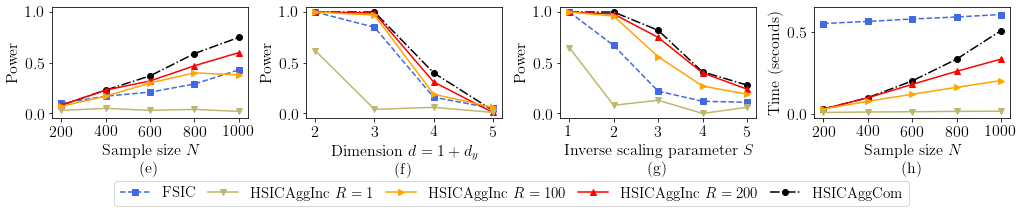

In [139]:
# HSIC
scale = 0.8
f, axs = plt.subplots(1, 4, figsize=(18 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = ["FSIC", r"HSICAggInc $R=1$", r"HSICAggInc $R=100$", r"HSICAggInc $R=200$", r"HSICAggCom"]
styles = ["--", "-", "-", "-", "-."]
markers = ["s", "v", ">", "^", "o"]
colors = ["royalblue", "darkkhaki", "orange", "red", "black"]
order = [4, 0, 3, 2, 1]

# Plot 0 HSIC vary n
idx = 0
power = hsic_vary_n
x_axis = x_axis_hsic_vary_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (e)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 HSIC vary d
idx = 1
power = hsic_vary_d
x_axis = x_axis_hsic_vary_d
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Dimension $d = 1+d_y$" + "\n (f)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 2 HSIC vary mult
idx = 2
power = np.load("results/hsic_vary_mult.npy")
x_axis = [1, 2, 3, 4, 5]
for j in order:
    axs[idx].plot(x_axis, np.mean(power, -1)[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Inverse scaling parameter $S$" + "\n (g)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 3 HSIC vary time
idx = 3
time_mean = hsic_time_mean
time_std = hsic_time_std
x_axis = x_axis_hsic_time
for j in order:
    axs[idx].errorbar(x_axis, time_mean[j], time_std[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (h)")
axs[idx].set_ylabel("Time (seconds)")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.03, 0.65)
axs[idx].set_yticks([0, 0.5])
handles, labels = axs[idx].get_legend_handles_labels()
handles = [h[0] for h in handles]
order_legend = (1, 4, 3, 2, 0) #(0, 1, 2, 3, 4, 5, 6)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-1.55, -0.85),
)

# Save HSIC Figure
f.savefig("figures/figure_hsic.eps", bbox_inches="tight")
f.savefig("figures/figure_hsic.png", dpi=300, bbox_inches="tight")

## KSD plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


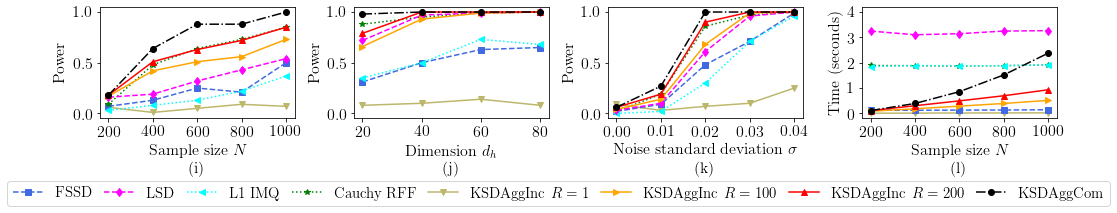

In [ ]:
# KSD
scale = 0.8
f, axs = plt.subplots(1, 4, figsize=(18 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = ["FSSD", "LSD", "L1IMQ", "Cauchy RFF", r"KSDAggInc $R=1$", r"KSDAggInc $R=100$", r"KSDAggInc $R=200$", r"KSDAggCom"]
styles = ["--", "--", ":", ":", "-", "-", "-", "-."]
markers = ["s", "d", "<", "*", "v", ">", "^", "o"]
colors = ["royalblue", "fuchsia", "cyan", "green", "darkkhaki", "orange", "red", "black"]
order = [4, 0, 3, 2, 1, 5, 6, 7]

# Plot 0 KSD vary n
idx = 0
power = ksd_vary_n
x_axis = x_axis_ksd_vary_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (i)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 KSD vary d
idx = 1
power = ksd_vary_d
x_axis = x_axis_ksd_vary_d
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Dimension $d_h$" + "\n (j)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 2 KSD vary sigma
idx = 2
power = ksd_vary_sigma
x_axis = x_axis_ksd_vary_sigma
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Noise standard deviation $\sigma$" + "\n (k)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 3 KSD vary time
idx = 3
time_mean = ksd_time_mean
time_std = ksd_time_std
x_axis = x_axis_ksd_time
for j in order:
    axs[idx].errorbar(x_axis, time_mean[j], time_std[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (l)")
axs[idx].set_ylabel("Time (seconds)")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.2, 4.2)
axs[idx].set_yticks([0, 1, 2, 3, 4])
handles, labels = axs[idx].get_legend_handles_labels()
handles = [h[0] for h in handles]
order_legend = (1, 4, 3, 2, 0, 5, 6, 7) #(1, 4, 3, 2, 0, 5, 6, 7)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=8,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-1.55, -0.85),
)

# Save KSD Figure
f.savefig("figures/figure_ksd_draw500.eps", bbox_inches="tight")
f.savefig("figures/figure_ksd_draw500.png", dpi=300, bbox_inches="tight")

# Collection Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


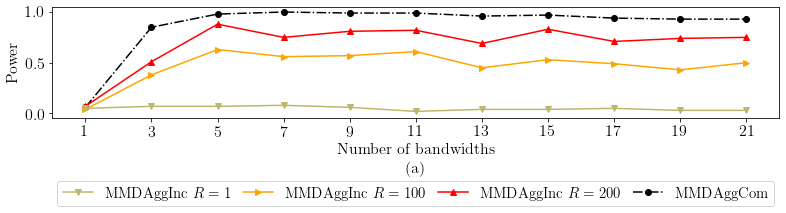

In [141]:
# MMD
scale = 0.8
f, axs = plt.subplots(1, 1, figsize=(14 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = [r"MMDAggInc $R=1$", r"MMDAggInc $R=100$", r"MMDAggInc $R=200$", r"MMDAggCom"]
styles = [ "-", "-", "-", "-."]
markers = [ "v", ">", "^", "o"]
colors = ["darkkhaki", "orange", "red", "black"]
order = [3, 2, 1, 0]

# Plot 0 MMD
power = mmd_vary_col
x_axis = x_axis_mmd_vary_col
for j in order:
    axs.plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs.set_xlabel(r"Number of bandwidths" + "\n (a)")
axs.set_ylabel("Power")
axs.set_xticks(x_axis)
axs.set_ylim(-0.05, 1.05)
axs.set_yticks([0, 0.5, 1])

handles, labels = axs.get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (3, 2, 1, 0) #(0, 1, 2, 3, 4, 5, 6)
axs.legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.85),
)

# Save KSD Figure
f.savefig("figures/figure_mmd_col.eps", bbox_inches="tight")
f.savefig("figures/figure_mmd_col.png", dpi=300, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


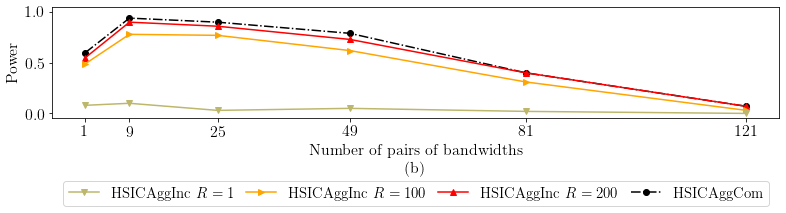

In [142]:
# HSIC
scale = 0.8
f, axs = plt.subplots(1, 1, figsize=(14 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = [r"HSICAggInc $R=1$", r"HSICAggInc $R=100$", r"HSICAggInc $R=200$", r"HSICAggCom"]
styles = [ "-", "-", "-", "-."]
markers = [ "v", ">", "^", "o"]
colors = ["darkkhaki", "orange", "red", "black"]
order = [3, 2, 1, 0]

# Plot 0 HSIC
power = hsic_vary_col
x_axis = x_axis_hsic_vary_col
for j in order:
    axs.plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs.set_xlabel(r"Number of pairs of bandwidths" + "\n (b)")
axs.set_ylabel("Power")
axs.set_xticks(x_axis)
axs.set_ylim(-0.05, 1.05)
axs.set_yticks([0, 0.5, 1])

handles, labels = axs.get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (3, 2, 1, 0) #(0, 1, 2, 3, 4, 5, 6)
axs.legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.85),
)

# Save HSIC Figure
f.savefig("figures/figure_hsic_col.eps", bbox_inches="tight")
f.savefig("figures/figure_hsic_col.png", dpi=300, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


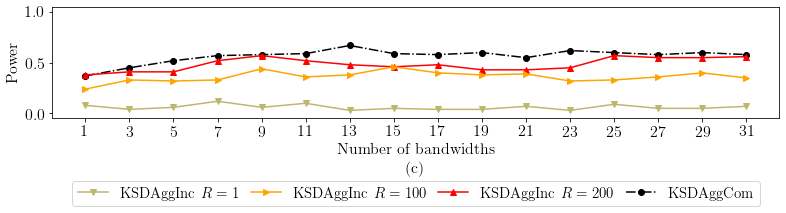

In [143]:
# KSD
scale = 0.8
f, axs = plt.subplots(1, 1, figsize=(14 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = [r"KSDAggInc $R=1$", r"KSDAggInc $R=100$", r"KSDAggInc $R=200$", r"KSDAggCom"]
styles = [ "-", "-", "-", "-."]
markers = [ "v", ">", "^", "o"]
colors = ["darkkhaki", "orange", "red", "black"]
order = [3, 2, 1, 0]

# Plot 0 KSD
power = ksd_vary_col
x_axis = x_axis_ksd_vary_col
for j in order:
    axs.plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs.set_xlabel(r"Number of bandwidths" + "\n (c)")
axs.set_ylabel("Power")
axs.set_xticks(x_axis)
axs.set_ylim(-0.05, 1.05)
axs.set_yticks([0, 0.5, 1])

handles, labels = axs.get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (3, 2, 1, 0) #(0, 1, 2, 3, 4, 5, 6)
axs.legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.85),
)

# Save KSD Figure
f.savefig("figures/figure_ksd_col.eps", bbox_inches="tight")
f.savefig("figures/figure_ksd_col.png", dpi=300, bbox_inches="tight")

# MNIST Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


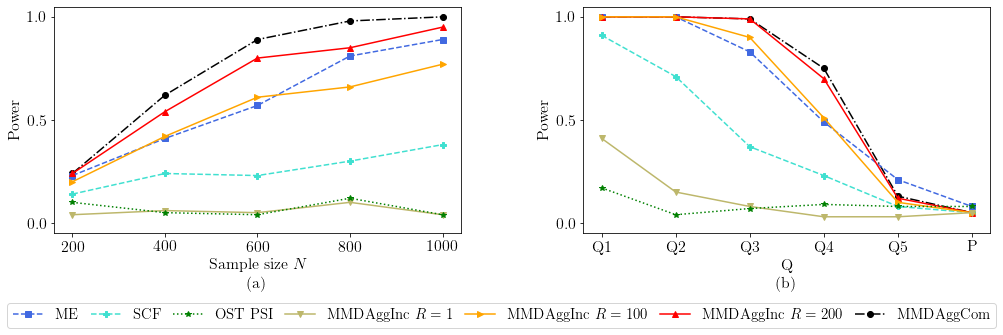

In [144]:
# MMD
scale = 1
f, axs = plt.subplots(1, 2, figsize=(14 * scale, 4 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = ["ME", "SCF", "OST PSI", r"MMDAggInc $R=1$", r"MMDAggInc $R=100$", r"MMDAggInc $R=200$", r"MMDAggCom"]
styles = ["--", "--", "dotted", "-", "-", "-", "-."]
markers = ["s", "P", "*", "v", ">", "^", "o"]
colors = ["royalblue", "turquoise", "green", "darkkhaki", "orange", "red", "black"]
order = [6, 1, 0, 5, 4, 3, 2]

# Plot 0 MMD
idx = 0
power = mmd_mnist_n
x_axis = x_axis_mmd_mnist_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (a)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 MMD
idx = 1
power = mmd_mnist_q
x_axis = x_axis_mmd_mnist_q
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Q" + "\n (b)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

handles, labels = axs[idx].get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (2, 1, 6, 5, 4, 3, 0) #(0, 1, 2, 3, 4, 5, 6)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-0.2, -0.45),
)

# Save MMD Figure
f.savefig("figures/figure_mmd_mnist.eps", bbox_inches="tight")
f.savefig("figures/figure_mmd_mnist.png", dpi=300, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


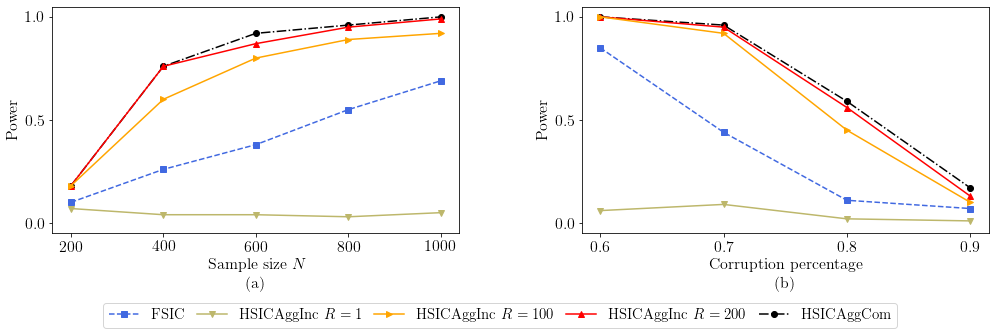

In [145]:
# HSIC
scale = 1
f, axs = plt.subplots(1, 2, figsize=(14 * scale, 4 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = ["FSIC", r"HSICAggInc $R=1$", r"HSICAggInc $R=100$", r"HSICAggInc $R=200$", r"HSICAggCom"]
styles = ["--", "-", "-", "-", "-."]
markers = ["s", "v", ">", "^", "o"]
colors = ["royalblue", "darkkhaki", "orange", "red", "black"]
order = [4, 0, 3, 2, 1]

# Plot 0 HSIC
idx = 0
power = hsic_mnist_n
x_axis = x_axis_hsic_mnist_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (a)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 HSIC
idx = 1
power = hsic_mnist_c
x_axis = x_axis_hsic_mnist_c
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Corruption percentage" + "\n (b)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

handles, labels = axs[idx].get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (1, 4, 3, 2, 0) #(0, 1, 2, 3, 4, 5, 6)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-0.2, -0.45),
)

# Save HSIC Figure
f.savefig("figures/figure_hsic_mnist.eps", bbox_inches="tight")
f.savefig("figures/figure_hsic_mnist.png", dpi=300, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


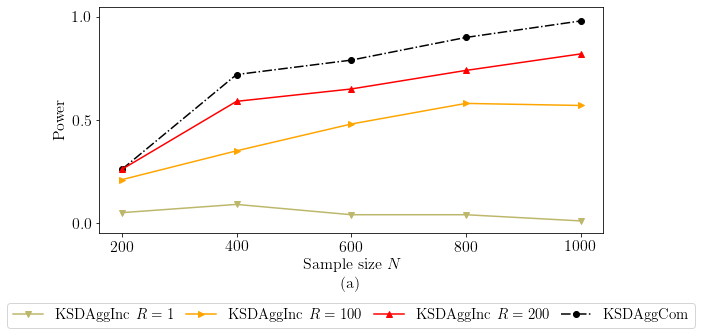

In [146]:
# KSD
scale = 1
f, axs = plt.subplots(1, 1, figsize=(8 * scale, 4 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = [r"KSDAggInc $R=1$", r"KSDAggInc $R=100$", r"KSDAggInc $R=200$", r"KSDAggCom"]
styles = [ "-", "-", "-", "-."]
markers = [ "v", ">", "^", "o"]
colors = ["darkkhaki", "orange", "red", "black"]
order = [3, 2, 1, 0]

# Plot 0 KSD
idx = 0
power = ksd_mnist_p
x_axis = x_axis_ksd_mnist_p
for j in order:
    axs.plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs.set_xlabel(r"Sample size $N$" + "\n (a)")
axs.set_ylabel("Power")
axs.set_xticks(x_axis)
axs.set_ylim(-0.05, 1.05)
axs.set_yticks([0, 0.5, 1])

handles, labels = axs.get_legend_handles_labels()
handles = [h for h in handles]
order_legend = (3, 2, 1, 0) #(0, 1, 2, 3, 4, 5, 6)
axs.legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=7,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.45),
)

# Save KSD Figure
f.savefig("figures/figure_ksd_mnist.eps", bbox_inches="tight")
f.savefig("figures/figure_ksd_mnist.png", dpi=300, bbox_inches="tight")

# RFF L1 IMQ Plot

In [ ]:
tests_names = ["L1IMQ 5000", "Cauchy RFF 5000",  r"KSDAggInc $R=200$", "L1IMQ 500", "Cauchy RFF 500"]

ksd_vary_n_draws = np.array([
    np.mean(np.load("results/ksd_vary_n_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_n_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_n_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_n_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_n_rff_l1imq_n500.npy"),-1)[0],
])

ksd_vary_d_draws = np.array([
    np.mean(np.load("results/ksd_vary_d_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_d_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_d_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_d_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_d_rff_l1imq_n500.npy"),-1)[0],
])

ksd_vary_sigma_draws = np.array([
    np.mean(np.load("results/ksd_vary_sigma_m10.npy"), -1)[4],
    np.mean(np.load("results/ksd_vary_sigma_rff.npy"),-1)[0],
    np.mean(np.load("results/ksd_vary_sigma_m10.npy"), -1)[2],
    np.mean(np.load("results/ksd_vary_sigma_rff_l1imq_n500.npy"),-1)[1],
    np.mean(np.load("results/ksd_vary_sigma_rff_l1imq_n500.npy"),-1)[0],
])

ksd_time_mean_draws = np.load("results/time_ksd_vary_n_mean_draws.npy")[[1, 3, 4, 0, 2]]
ksd_time_std_draws = np.load("results/time_ksd_vary_n_std_draws.npy")[[1, 3, 4, 0, 2]]

x_axis_ksd_vary_n = [200, 400, 600, 800, 1000]
x_axis_ksd_vary_sigma = [200, 400, 600, 800, 1000]
x_axis_ksd_time = [200, 400, 600, 800, 1000]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


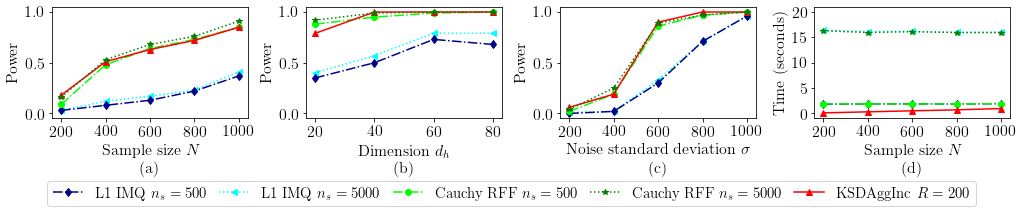

In [ ]:
# KSD
scale = 0.8
f, axs = plt.subplots(1, 4, figsize=(18 * scale, 3 * scale))
f.tight_layout()
f.subplots_adjust(wspace=0.3, hspace=1.6)

# Parameters
tests_names = [r"L1IMQ $n_s=5000$", r"Cauchy RFF $n_s=5000$",  r"KSDAggInc $R=200$", r"L1IMQ $n_s=500$", r"Cauchy RFF $n_s=500$"]
styles = [ ":", ":", "-", "-.", "-."]
markers = [ "<", "*", "^", "d", "o"]
colors = ["cyan", "green",  "red", "darkblue", "lime"]
order = [0, 3, 4, 2, 1]

# Plot 0 KSD vary n
idx = 0
power = ksd_vary_n_draws
x_axis = x_axis_ksd_vary_n
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (a)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 1 KSD vary d
idx = 1
power = ksd_vary_d_draws
x_axis = x_axis_ksd_vary_d
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Dimension $d_h$" + "\n (b)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 2 KSD vary sigma
idx = 2
power = ksd_vary_sigma_draws
x_axis = x_axis_ksd_vary_sigma
for j in order:
    axs[idx].plot(x_axis, power[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Noise standard deviation $\sigma$" + "\n (c)")
axs[idx].set_ylabel("Power")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-0.05, 1.05)
axs[idx].set_yticks([0, 0.5, 1])

# Plot 3 HSIC vary mult
idx = 3
time_mean = ksd_time_mean_draws
time_std = ksd_time_std_draws
x_axis = x_axis_ksd_time
for j in order:
    axs[idx].errorbar(x_axis, time_mean[j], time_std[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j])
axs[idx].set_xlabel(r"Sample size $N$" + "\n (d)")
axs[idx].set_ylabel("Time (seconds)")
axs[idx].set_xticks(x_axis)
axs[idx].set_ylim(-1, 21)
axs[idx].set_yticks([0, 5, 10, 15, 20])
handles, labels = axs[idx].get_legend_handles_labels()
handles = [h[0] for h in handles]
order_legend = (1, 0, 2, 4, 3)
axs[idx].legend(
    (handles[index] for index in order_legend),
    (labels[index] for index in order_legend),
    fontsize=15,
    ncol=8,
    handleheight=0.5,
    labelspacing=0.4,
    columnspacing=0.8,
    loc="lower center",
    bbox_to_anchor=(-1.55, -0.85),
)

# Save KSD Figure
f.savefig("figures/figure_ksd_draws.eps", bbox_inches="tight")
f.savefig("figures/figure_ksd_draws.png", dpi=300, bbox_inches="tight")

# Level

## Level MMD vary N

In [38]:
%%capture
f_theta_seed = 0
p = 2
s = 1 # useless with our scaling
perturbation_multiplier = 5
d = 1
rep = 200
mult = 2

tests_mmd_vary_n = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_n = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_mmd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_mmd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        X = rs.uniform(0, 1, (N, d)) 
        Y = rs.uniform(0, 1, (N, d)) 
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/level_mmd_vary_n.npy", outputs_mmd_vary_n)

[[0.055 0.005 0.045 0.04  0.05  0.055 0.055]
 [0.08  0.01  0.04  0.035 0.06  0.03  0.03 ]
 [0.08  0.005 0.105 0.085 0.04  0.04  0.07 ]
 [0.05  0.005 0.055 0.075 0.03  0.035 0.055]
 [0.075 0.005 0.045 0.045 0.015 0.02  0.05 ]]


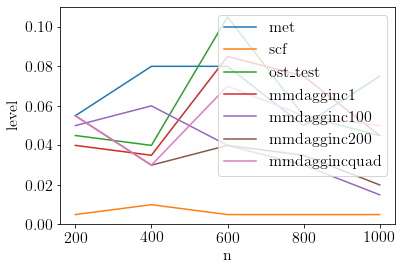

In [147]:
power = np.load("results/level_mmd_vary_n.npy")
tests_names = tests_names_mmd_vary_n
x_axis = x_axis_mmd_vary_n
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("level")
print(np.mean(power, -1).T)

## Level MMD vary d

In [39]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 200
N = 1000
mult = 1

tests_mmd_vary_d = [met, scf, ost_test, mmdagginc1, mmdagginc100, mmdagginc200, mmdaggincquad]
tests_names_mmd_vary_d = ["met", "scf", "ost_test", "mmdagginc1", "mmdagginc100", "mmdagginc200", "mmdaggincquad"]
tests = tests_mmd_vary_d

d_values = [1, 2, 3, 4]
x_axis_mmd_vary_d = d_values
outputs_mmd_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, d))
        Y = rs.uniform(0, 1, (N, d))
        for j in range(len(tests)):
            test = tests[j]
            outputs_mmd_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/level_mmd_vary_d.npy", outputs_mmd_vary_d)

[[0.045 0.    0.035 0.02  0.045 0.04  0.045]
 [0.045 0.035 0.085 0.1   0.05  0.04  0.035]
 [0.04  0.05  0.04  0.04  0.05  0.06  0.025]
 [0.045 0.05  0.03  0.055 0.045 0.045 0.03 ]]


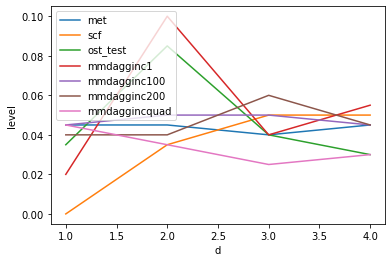

In [51]:
power = np.load("results/level_mmd_vary_d.npy")
tests_names = tests_names_mmd_vary_d
x_axis = x_axis_mmd_vary_d
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("level")
print(np.mean(power, -1).T)

## Level HSIC vary n

In [40]:
%%capture
f_theta_seed = 0
p = 2 
s = 1 # useless with our scaling
d = 2 # dx = 1 and dy = 1
rep = 200
mult = 2 

tests_hsic_vary_n = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_n = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_hsic_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_hsic_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult
        #Z = f_theta_sampler(f_theta_seed, seed, N, p, s, perturbation_multiplier, d)
        #X = np.expand_dims(Z[:, 0], 1)
        #Y = np.expand_dims(Z[:, 1], 1)
        X = rs.uniform(0, 1, (N, 1))
        Y = rs.uniform(0, 1, (N, 1))
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_n[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/level_hsic_vary_n.npy", outputs_hsic_vary_n)

[[0.04  0.055 0.035 0.035 0.035]
 [0.045 0.05  0.04  0.05  0.05 ]
 [0.05  0.035 0.05  0.06  0.05 ]
 [0.03  0.07  0.02  0.035 0.04 ]
 [0.07  0.02  0.085 0.035 0.04 ]]


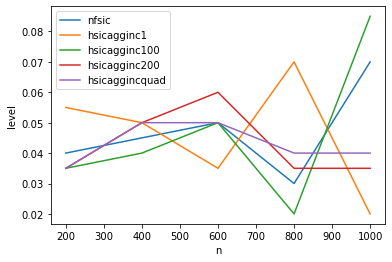

In [52]:
power = np.load("results/level_hsic_vary_n.npy")
tests_names = tests_names_hsic_vary_n
x_axis = x_axis_hsic_vary_n
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("level")
print(np.mean(power, -1).T) 

## Level HSIC vary d

In [41]:
%%capture 
f_theta_seed = 0
p = 1
s = 1 # useless
rep = 200
N = 1000
mult = 1

tests_hsic_vary_d = [nfsic, hsicagginc1, hsicagginc100, hsicagginc200, hsicaggincquad]
tests_names_hsic_vary_d = ["nfsic", "hsicagginc1", "hsicagginc100", "hsicagginc200", "hsicaggincquad"]
tests = tests_hsic_vary_d

d_values = [1, 2, 3, 4] # this is dx = 1 and dy = 1, 2, 3, 4
x_axis_hsic_vary_d = d_values
outputs_hsic_vary_d = np.zeros((len(tests), len(d_values), rep))
rs = np.random.RandomState(0)
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(d_values)):
        d = d_values[r]
        seed += 1
        perturbation_multiplier = np.exp(d) * p ** s / mult 
        X = rs.uniform(0, 1, (N, 1))
        Y = rs.uniform(0, 1, (N, d))
        for j in range(len(tests)):
            test = tests[j]
            outputs_hsic_vary_d[j][r][i] = test(X, Y, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)     
np.save("results/level_hsic_vary_d.npy", outputs_hsic_vary_d)

[[0.035 0.065 0.08  0.055 0.07 ]
 [0.065 0.055 0.035 0.02  0.025]
 [0.04  0.035 0.045 0.055 0.055]
 [0.055 0.07  0.03  0.025 0.02 ]]


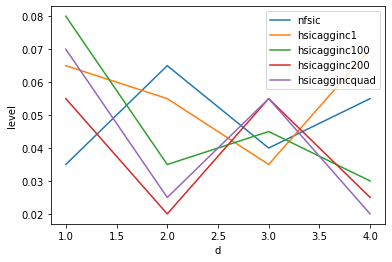

In [53]:
power = np.load("results/level_hsic_vary_d.npy")
tests_names = tests_names_hsic_vary_d
x_axis = x_axis_hsic_vary_d
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d") 
    plt.ylabel("level")
print(np.mean(power, -1).T)

## Level KSD vary n

In [42]:
%%capture
sigma = 0 # level
dx = 50
dh = 40
rep = 200

tests_ksd_vary_n = [fssd, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad, lsd_test]
tests_names_ksd_vary_n = ["fssd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad", "lsd"]
tests = tests_ksd_vary_n

N_values = [200, 400, 600, 800, 1000]
outputs_ksd_vary_n = np.zeros((len(tests), len(N_values), rep))
rs = np.random.RandomState(0)
x_axis_ksd_vary_n = N_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(N_values)):
        N = N_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            if test == lsd_test: 
                p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
                outputs_ksd_vary_n[j][r][i] = test(X, p_dist, seed)
            else:
                outputs_ksd_vary_n[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time()-t0)       
np.save("results/level_ksd_vary_n.npy", outputs_ksd_vary_n)

[[0.02  0.05  0.045 0.06  0.06  0.07 ]
 [0.03  0.06  0.04  0.065 0.055 0.04 ]
 [0.04  0.03  0.03  0.04  0.07  0.075]
 [0.03  0.055 0.06  0.045 0.07  0.06 ]
 [0.025 0.045 0.035 0.045 0.065 0.05 ]]


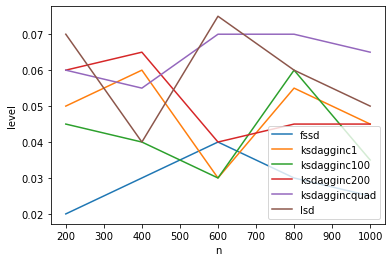

In [ ]:
power = np.load("results/level_ksd_vary_n.npy")
tests_names = tests_names_ksd_vary_n
x_axis = x_axis_ksd_vary_n
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("level")
print(np.mean(power, -1).T) 

## Level KSD vary d

In [ ]:
%%capture 
sigma = 0 # level
N = 1000
rep = 200

dx = 100

tests_ksd_vary_d = [fssd, ksdagginc1, ksdagginc100, ksdagginc200, ksdaggincquad, lsd_test]
tests_names_ksd_vary_d = ["fssd", "ksdagginc1", "ksdagginc100", "ksdagginc200", "ksdaggincquad", "lsd"]
tests = tests_ksd_vary_d

dx_values = [20, 40, 60, 80]
outputs_ksd_vary_d = np.zeros((len(tests), len(dx_values), rep))
x_axis_ksd_vary_d = dx_values
seed = 0
for i in range(rep):
    t0 = time.time()
    for r in range(len(dx_values)):
        dh = dx_values[r]
        seed += 1
        X, p = generate_rbm(
            seed,
            N,
            sigma,
            dx, 
            dh,
        ) 
        for j in range(len(tests)):
            test = tests[j]
            if test == lsd_test: 
                p_dist = generate_rbm_p(seed, N, sigma, dx, dh)
                outputs_ksd_vary_d[j][r][i] = test(X, p_dist, seed)
            else:
                outputs_ksd_vary_d[j][r][i] = test(X, p, seed)
    print(i + 1, "/", rep, "time:", time.time() - t0)       
np.save("results/level_ksd_vary_d.npy", outputs_ksd_vary_d)

[[0.02  0.045 0.06  0.065 0.05  0.055]
 [0.04  0.07  0.055 0.065 0.07  0.055]
 [0.04  0.06  0.04  0.05  0.06  0.055]
 [0.015 0.045 0.04  0.035 0.05  0.04 ]]


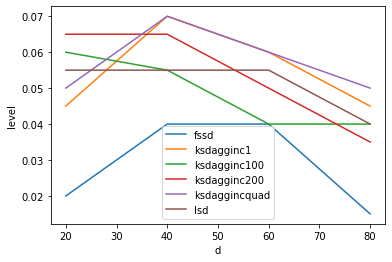

In [55]:
power = np.load("results/level_ksd_vary_d.npy")
tests_names = tests_names_ksd_vary_d
x_axis = x_axis_ksd_vary_d
for j in range(len(tests_names)):
    plt.plot(x_axis, np.mean(power, -1)[j], label=tests_names[j])
    plt.legend()
    plt.xlabel("d")
    plt.ylabel("level")
print(np.mean(power, -1).T)